# Novelty detection using LSTMs

In 2015, a paper titled ["A NOVEL APPROACH FOR AUTOMATIC ACOUSTIC NOVELTY DETECTION USING A DENOISING AUTOENCODER WITH BIDIRECTIONAL LSTM NEURAL NETWORKS"](https://mediatum.ub.tum.de/doc/1253789/file.pdf), authored by Erik Marchi, Fabio Vesperini, Florian Eyben, Stefano Squartini and Bjorn Schuller.
The paper achieved state-of-the-art results in novelty detection, and proposed an automatic acoustic anomaly dection method using Bidirectional LSTM networks. This notebook is a PyTorch implementation of the "Denoise novelty detection model" (**BLSTM-DAE** for short) based on this paper.

**Table of contents:**

0. [Preparation](#sec0)
1. [Dataset](#sec1)
2. [LSTM Autoencoder](#sec2)
3. [Bidirectional LSTM Autoencoder](#sec3)
4. [Denoise Bidirectional LSTMs Autoencoder](#sec4)
5. [Conclusion](#sec5)

# <a id="sec0"></a>0. Preparation

In this notebook, we'll be using `torch` and `torchinfo`, which we have already used in previous AML courses. Run the following code cells to install the necessary packages and verify that everything is working by importing everything. If it doesn't work, install the libraries manually using either `pip install` or `conda install`.

Please refer to the [PyTorch](https://pytorch.org/get-started/locally/) website for installation instructions if necessary. We'll also be using packages `sklearn`, `numpy`, and `matplotlib`.

<div class="alert alert-danger">

Note that this notebook is fairly compute intensive and it might be better to **[run in Google Colab](https://colab.research.google.com).**
    
If you use Colab, mind yourself to **add data file**  to it, which is named **"ECG5000.csv"** Then change alter default hardware CPU to **GPU**: just follow `Edit` > `Notebook settings` or `Runtime` > `Change runtime type` and select `GPU` as Hardware accelerator.
       
</div>

In [1]:
# !pip install torchinfo
# !pip install torch
# !pip install tqdm

In [1]:
import torch
import copy
import time
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch import nn, optim
import torch.nn.functional as F
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# <a id="sec1"></a>1. Dataset: ECG5000

The [dataset](https://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

<div class="alert alert-info">

An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart.

We have 5 types of [heartbeats](https://en.wikipedia.org/wiki/Cardiac_cycle):
- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB)

</div>

Here, the original data(of type 'arff') is already tranformed to type 'csv', which is named **"ECG5000.csv"**. Let's load the data and see what does it look like.

**If you are using Colab，please run this block to load resources.**

In [ ]:
# !wget https://raw.githubusercontent.com/S-Guowei/SDD-AML-DL-Novelty_detection_LSTM/master/ECG5000.csv
# !mkdir models
# !wget -P /content/models https://raw.githubusercontent.com/S-Guowei/SDD-AML-DL-Novelty_detection_LSTM/master/models/history_LSTM.json
# !wget -P /content/models https://raw.githubusercontent.com/S-Guowei/SDD-AML-DL-Novelty_detection_LSTM/master/models/history_BLSTM.json
# !wget -P /content/models https://raw.githubusercontent.com/S-Guowei/SDD-AML-DL-Novelty_detection_LSTM/master/models/history_BLSTM_DAE.json
# !wget https://github.com/S-Guowei/SDD-AML-DL-Novelty_detection_LSTM/blob/master/models/model_LSTM.pth
# !wget https://github.com/S-Guowei/SDD-AML-DL-Novelty_detection_LSTM/blob/master/models/model_BLSTM.pth
# !wget https://github.com/S-Guowei/SDD-AML-DL-Novelty_detection_LSTM/blob/master/models/model_BLSTM_DAE.pth
# !mv model_LSTM.pth /content/models
# !mv model_BLSTM.pth /content/models
# !mv model_BLSTM_DAE.pth /content/models

In [2]:
df = pd.read_csv('./ECG5000.csv')
df.head(5)

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


We have 5,000 examples. Each row represents a single heartbeat record. And the column 'target' marks the type of heartbeats, 'target = 1' represents the normal situation. Now let's expolre more about this dataset.

Firstly, Let’s check how many examples for each heartbeat class do we have:

In [3]:
df.target.value_counts()

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64

Les's show it:

[Text(0, 0, 'Normal'),
 Text(1, 0, 'R on T'),
 Text(2, 0, 'PVC'),
 Text(3, 0, 'SP'),
 Text(4, 0, 'UB')]

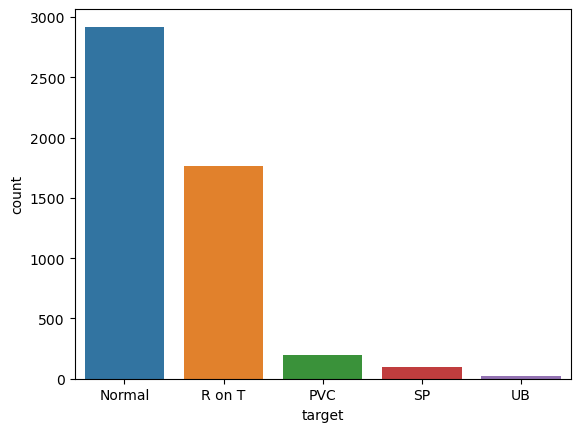

In [4]:
class_names = ['Normal','R on T','PVC','SP','UB']
ax = sns.countplot(x="target", data=df, order = df['target'].value_counts().index)
ax.set_xticklabels(class_names)

Through statistical analysis, we found that the normal class had the most samples. This result is very desirable and expected (anomalies in anomaly detection tend to be the least abnormal), again because we need to use this data from the normal class to train the model.

Next, we look at the average time series for each class (with a standard deviation smoothing done before and after).

First define an auxiliary plotting function.

In [5]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    """
    param data: dataset(dataframe)
    param class_name: type list
    param ax
    """
    time_series_df = pd.DataFrame(data)
    # smooth data windows
    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()
    # defie limits
    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]
    # plot smooth figures
    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
      path_deviation.index,
      under_line,
      over_line,
      alpha=.125)
    ax.set_title(class_name)

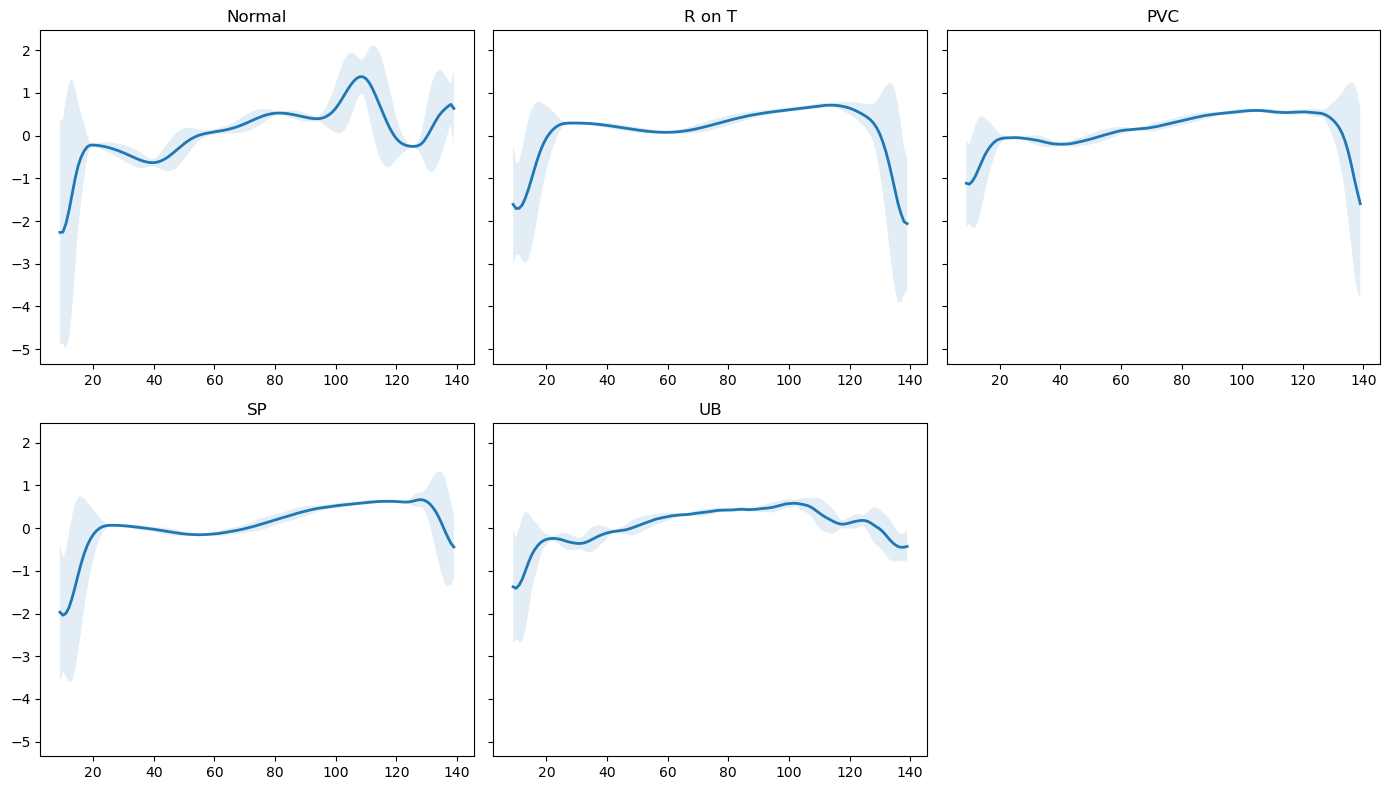

In [6]:
# get different types
classes = df.target.unique()
# define figures
fig, axs = plt.subplots(
      nrows=len(classes) // 3 + 1,
      ncols=3,
      sharey=True,
      figsize=(14, 8))
# plot
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
      .drop(labels='target', axis=1) \
      .mean(axis=0) \
      .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

Based on the visualization results of the five heartbeat classes above, it is seen that the normal class has characteristics that are significantly different from all the other classes, which may be the key to the ability of the model we constructed to detect anomalies.

# <a id="sec2"></a>2. LSTM Autoencoder

## 2.1 Conceptions

### **LSTM networks**

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by [Hochreiter & Schmidhuber (1997)](https://www.bioinf.jku.at/publications/older/2604.pdf), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. LSTMs also have the chain like structure like RNN networks, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<img src="img/LSTM3-chain.png" width="600"></img>
<img src="img/LSTM2-notation.png" width="600"></img>

In the above diagram, each line carries an entire vector, from the output of one node to the inputs of others. The pink circles represent pointwise operations, like vector addition, while the yellow boxes are learned neural network layers. Lines merging denote concatenation, while a line forking denote its content being copied and the copies going to different locations.

<img src="img/LSTM4.png" width="900"></img>

The first step in our LSTM is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “forget gate layer.” It looks at $h_{t-1}$ and $x_t$, and outputs a number between **$0$** and **$1$** for each number in the cell state $C_{t−1}$. A **$1$** represents “completely keep this” while a **$0$** represents “completely get rid of this.”

The next step is to decide what new information we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “input gate layer” decides which values we’ll update. Next, a tanh layer creates a vector of new candidate values, $\widetilde{C_t}$, that could be added to the state. In the next step, we’ll combine these two to create an update to the state.

It’s now time to update the old cell state, $C_{t−1}$, into the new cell state $C_t$.  The previous steps already decided what to do, we just need to actually do it. We multiply the old state by $f_t$, forgetting the things we decided to forget earlier. Then we add $i_t*\widetilde{C_t}$. This is the new candidate values, scaled by how much we decided to update each state value.

Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.

For more details, you can click [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

###  **Autoencoder model**

<img src="img/autoencoder.png" width="600"></img>

An [**autoencoder model**](https://lilianweng.github.io/posts/2018-08-12-vae/) is a neural network designed to learn constant functions in an unsupervised manner to reconstruct the original input while compressing the data in the process to discover a more efficient and compressed representation. The network can be seen as consisting of two parts: an encoder function $h=f(x)$ and a decoder $r=g(x)$ that generates the reconstruction

- Encoder network: converts raw high-dimensional inputs into potential low-dimensional code. Input size is larger than output size.
- Decoder network: the decoder network recovers data from the code, with a potentially increasingly large output layer.

The encoder network essentially accomplishes dimensionality reduction, much like how we use principal component analysis (PCA) or matrix factorization (MF). In addition, autoencoders are explicitly optimized for data reconstruction in code. A good intermediate representation not only captures latent variables, but also facilitates the complete decompression process.

The model contains an encoder function $g(.)$ parameterized by $\phi$, a decoder function $f(.)$ parameterized by $\theta$ and a bottleneck layer $Z$. And reconstructed output is ${x}'=f_{\theta}(g_{\phi}(x))$

The parameters $(\theta,\phi)$ are learned together to output reconstructed data samples identical to the original inputs. This processing will minimise the reconstruction error, which corresponds to minimising the following loss function:

$$J(\theta)=\sum_{x\in \chi }\left \| x-{x}' \right \|^2$$

There are also various metrics to quantify the difference between two vectors, such as cross-entropy when the activation function is sigmoid, or L1Loss.

<div class="alert alert-info">

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we’ll have a look at how to feed Time Series data to an Autoencoder. We’ll use a couple of **LSTM layers** (hence the **LSTM Autoencoder**) to capture the temporal dependencies of the data.

</div>

### **[Novelty detection](https://mediatum.ub.tum.de/doc/1253789/file.pdf)**

Novelty detection is the process of identifying new or unknown data or patterns in a dataset that a machine learning system has not been exposed to during training. It is a critical aspect of machine learning, particularly in unsupervised learning scenarios where the goal is to discover unusual data points, events, or observations that may signify significant or interesting changes in the data.

<img src="img/novelty.png" width="600"></img>

We will train the model by normal dataset, then give the anomaly dataset to trained model to see how loss varies. **To classify a sequence as normal or an anomaly, we’ll pick a threshold of loss between input and reconstructed output, above which a heartbeat is considered abnormal.**

## 2.2 Train and test

### 2.2.1 Create datasets
 


Firstly, we split the data into to big groups of `normal_df` and `anomaly_df` according to target.

In [7]:
normal_df = df[df['target'] == 1].drop(labels='target', axis=1)
print(f"shape of normal_df: {normal_df.shape}")
anomaly_df = df[df['target'] != 1].drop(labels='target', axis=1)
print(f"shape of anomaly_df: {anomaly_df.shape}")

shape of normal_df: (2919, 140)
shape of anomaly_df: (2081, 140)


Then we split `normal_df` into `train_df` for training and `val_df` for validation during training. And split 33% of the `val_df` as `test_df` for resting.

In [8]:
train_df, val_df = train_test_split(normal_df,test_size=0.15,random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df,test_size=0.33, random_state=RANDOM_SEED)

<img src="img/LSTM5.png" width="500"></img>

Now we translate the train data into a 3-dimension tensor dataset according to [Pytorch document](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html). As we can see in the picture, the input shape is **(number_samples, time_sequence, number_features)** .

In [9]:
def create_dataset(df):
    """To create a dataset by dataframe, return as
    (dataset, sample_num, seq_len, n_features)
    """
    X_train_list = df.astype(np.float32).to_numpy().tolist()
    samples = []
    for sequence in X_train_list:
        samples.append(np.array(sequence).reshape(len(sequence),-1))
    X_train = np.array(samples)
    dataset = TensorDataset(torch.Tensor(X_train))
    sample_num, seq_len, n_features = X_train.shape
    return dataset, sample_num, seq_len, n_features

In [10]:
train_dataset, _, seq_len, n_features = create_dataset(train_df)
val_dataset,_, _, _ = create_dataset(val_df)
test_normal_dataset,_, _, _ = create_dataset(test_df)
test_anomaly_dataset,_, _, _ = create_dataset(anomaly_df)

### 2.2.2 Create model

Then we start to create our model. Here we want to build an encoder with two layers of LSTM units. By default, The first layer has a hidden layer of dimension 128 and second layer also has one hidden layer of 64-dims. Since the output of LSTM unit is of shape (n_samples, time_sequence, n_features), we need to compress the data at the end of encoder and keep the information as much as posssible. So we take `hidden_n` as output of this encoder, it represents the hidden state of the LSTM at the last time step of shape **(num_layers*num_directions, batch_size, hidden_size)**. Then we reshape the vector to **(batch_size, hidden_size)**.

<div class="alert alert-info">

Parameters of class **torch.nn.LSTM**:

- **input_size** – The number of expected features in the input x
- **hidden_size** – The number of features in the hidden state h
- **num_layers** – Number of recurrent layers.
- **batch_first** – If `True`, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). 
- **bidirectional** – If `True`, becomes a bidirectional LSTM. Default: `False`

</div>

What's more, the output dimension is the same as hidden layer dimension if it is not bidirectional. So we can summary the architecture of this encoder with `batch_size = 30`, `seq_len = 140`, `n_features = 1` and `embedding_dim = 64`:

- Input: (30,140,1)
- LSTM1: (30,140,1) -> (30,140,128)
- LSTM2: (30,140,128) -> (30,140,64)
- Linear reshape: (30,140,64) -> (30,64)

In [11]:
class LSTM_Encoder(nn.Module):

#Define a subclass of encoder that inherits from the parent class nn.Modul

  def __init__(self, seq_len, n_features, embedding_dim=64):
      super(LSTM_Encoder, self).__init__()

      self.seq_len, self.n_features = seq_len, n_features
      self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

  # use to layers of LSTMs
      self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True)

      self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True)


  def forward(self, x):
      x, _ = self.rnn1(x)
      x, (hidden_n, _) = self.rnn2(x)
      # shape of hidden_n：(num_layers*num_directions, batch_size, embedding_dim)
      hidden_n = hidden_n.permute(1,0,2)
      return hidden_n.reshape((-1,self.embedding_dim))

To preview the output size of encoder 

In [12]:
encoder = LSTM_Encoder(seq_len=seq_len, n_features=n_features)
x = torch.randn((30, seq_len, n_features))
output = encoder(x)
print(f"The shape after encoding of input ([30,140,1]): {output.shape}")

The shape after encoding of input ([30,140,1]): torch.Size([30, 64])


The same way of encoder, we go to the part of decoder. There are two layers of LSTM units with single hiddden layer of dimension 128 and 64, respectively. To fit the output of encoder, we need to reshape input to 3-dimension again and repeat it for `seq_len` times at the dimension of time sequence. At the end of this encoder, we have a linear layer who transform n_features to the original size of $x$.

- Input: (30,64)
- Reshape: (30,64) -> (30,1,64)
- Repeat: (30,1,64) -> (30,140,64)
- LSTM1: (30,140,64) -> (30,140,128)
- LSTM2: (30,140,128) -> (30,140,64)
- Linear layer: (30,140,64) -> (30,140,1)

In [13]:
class LSTM_Decoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64,):
      super(LSTM_Decoder, self).__init__()

      self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
      self.seq_len, self.n_features = seq_len, n_features

      self.rnn1 = nn.LSTM(
        input_size=self.embedding_dim,
        hidden_size=self.hidden_dim,
        num_layers=1,
        batch_first=True)

      self.rnn2 = nn.LSTM(
        input_size=self.hidden_dim,
        hidden_size=self.embedding_dim,
        num_layers=1,
        batch_first=True)

      self.output_layer = nn.Linear(self.embedding_dim,self.n_features)

  def forward(self, x):
      x = x.reshape((-1,1,self.embedding_dim))
      x = x.repeat(1,self.seq_len,1)
      x, _ = self.rnn1(x)
      x, _ = self.rnn2(x)
      return self.output_layer(x)

To preview the output size of decoder 

In [42]:
output = torch.randn((30, 64))
decoder = LSTM_Decoder(seq_len, n_features, 64,)
output_decoder = decoder(output)
print(f"The shape after decoding of input ([30,64]): {output_decoder.shape}")

The shape after decoding of input ([30,64]): torch.Size([30, 140, 1])


Define a class `LSTM_Autoencoder` to assemble encoder and decoder.

In [15]:
class LSTM_Autoencoder(nn.Module):
    """
    Define a subclass of Autoencoder that inherits from the parent class
    nn.Module and the autoencoder passes the input through the encoder and decoder
    """
    def __init__(self, seq_len, n_features, hidden_dim=64):
        super(LSTM_Autoencoder, self).__init__()
        self.encoder = LSTM_Encoder(seq_len, n_features, hidden_dim).to(device)
        self.decoder = LSTM_Decoder(seq_len, n_features, hidden_dim).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Create a model `model_LSTM` and show its information.

In [16]:
model_LSTM = LSTM_Autoencoder(seq_len, n_features, 128)
model_LSTM = model_LSTM.to(device)
batch_size = 30 # assume that batch size is 30
summary(model_LSTM, input_size=(batch_size, 140, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_Autoencoder                         [30, 140, 1]              --
├─LSTM_Encoder: 1-1                      [30, 128]                 --
│    └─LSTM: 2-1                         [30, 140, 256]            265,216
│    └─LSTM: 2-2                         [30, 140, 128]            197,632
├─LSTM_Decoder: 1-2                      [30, 140, 1]              --
│    └─LSTM: 2-3                         [30, 140, 256]            395,264
│    └─LSTM: 2-4                         [30, 140, 128]            197,632
│    └─Linear: 2-5                       [30, 140, 1]              129
Total params: 1,055,873
Trainable params: 1,055,873
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.43
Input size (MB): 0.02
Forward/backward pass size (MB): 25.84
Params size (MB): 4.22
Estimated Total Size (MB): 30.08

### 2.2.3 Train model 

Now we create our data loaders: `train_loader` and `val_loader` by a given batch size (here `batch_size=60`)

In [17]:
batch_size = 60
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Write a train function to train. We choose `Adam` as optimizer and `MSE` as loss function. The autoencoder model is trained by **normal datasets**. The aime is to minimise loss between input and iutput, which means that the autoencoder can reconstruct the input signal well. 

In [18]:
def train_model(model, train_loader, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.MSELoss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in tqdm(range(1, n_epochs + 1),desc='Training'):
    model = model.train()
    train_losses = []

    for seq_true in train_loader:
      inputs = seq_true[0]
      optimizer.zero_grad()
      inputs = inputs.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, inputs)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item()/inputs.shape[0])

    val_losses = []
    model = model.eval()

    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true[0].unsqueeze(0)
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f' Epoch {epoch}: Train loss {train_loss:.5f} Validation loss {val_loss:.5f}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history


<div class="alert alert-danger">

- Skip the first block and run the second block for training. If you are using T4 GPU of Colab, the train process may take 3 mins. 

- Or, you can load the trained model and results and skip the second block in the following.

</div>

In [19]:
with open('./models/history_LSTM.json', 'r') as f:
    history = json.load(f)

model_LSTM = torch.load('./models/model_LSTM.pth', map_location=torch.device('cpu'))

In [20]:
# Here to run the precess of train, 3 mins for 80 epochs
start_time_train = time.time()
model_LSTM, history = train_model(
  model_LSTM,
  train_loader,
  val_dataset,
  n_epochs=75
)
end_time_train = time.time()
print(f"Train time: {end_time_train-start_time_train}s")

Training:   1%|▏         | 1/75 [00:03<04:29,  3.64s/it]

 Epoch 1: Train loss 100.98918 Validation loss 68.24364


Training:   3%|▎         | 2/75 [00:08<05:21,  4.41s/it]

 Epoch 2: Train loss 58.19243 Validation loss 49.63008


Training:   4%|▍         | 3/75 [00:12<04:50,  4.03s/it]

 Epoch 3: Train loss 48.96494 Validation loss 48.45262


Training:   5%|▌         | 4/75 [00:15<04:32,  3.84s/it]

 Epoch 4: Train loss 47.75800 Validation loss 46.94029


Training:   7%|▋         | 5/75 [00:19<04:29,  3.85s/it]

 Epoch 5: Train loss 46.32847 Validation loss 50.80993


Training:   8%|▊         | 6/75 [00:21<03:51,  3.35s/it]

 Epoch 6: Train loss 45.64634 Validation loss 44.09246


Training:   9%|▉         | 7/75 [00:24<03:25,  3.03s/it]

 Epoch 7: Train loss 43.56812 Validation loss 42.49966


Training:  11%|█         | 8/75 [00:26<03:08,  2.81s/it]

 Epoch 8: Train loss 42.07133 Validation loss 53.58983


Training:  12%|█▏        | 9/75 [00:28<02:55,  2.66s/it]

 Epoch 9: Train loss 43.04490 Validation loss 41.29583


Training:  13%|█▎        | 10/75 [00:33<03:39,  3.38s/it]

 Epoch 10: Train loss 40.51166 Validation loss 44.05841


Training:  15%|█▍        | 11/75 [00:36<03:15,  3.06s/it]

 Epoch 11: Train loss 39.00116 Validation loss 39.06327


Training:  16%|█▌        | 12/75 [00:38<02:59,  2.85s/it]

 Epoch 12: Train loss 38.64444 Validation loss 37.10997


Training:  17%|█▋        | 13/75 [00:41<02:46,  2.69s/it]

 Epoch 13: Train loss 36.94057 Validation loss 32.80801


Training:  19%|█▊        | 14/75 [00:43<02:37,  2.58s/it]

 Epoch 14: Train loss 42.28477 Validation loss 40.28902


Training:  20%|██        | 15/75 [00:45<02:34,  2.58s/it]

 Epoch 15: Train loss 40.66586 Validation loss 42.21389


Training:  21%|██▏       | 16/75 [00:48<02:27,  2.51s/it]

 Epoch 16: Train loss 39.39424 Validation loss 43.64646


Training:  23%|██▎       | 17/75 [00:50<02:22,  2.46s/it]

 Epoch 17: Train loss 35.68043 Validation loss 31.85597


Training:  24%|██▍       | 18/75 [00:53<02:19,  2.44s/it]

 Epoch 18: Train loss 35.88914 Validation loss 34.64035


Training:  25%|██▌       | 19/75 [00:56<02:26,  2.61s/it]

 Epoch 19: Train loss 33.73822 Validation loss 37.04990


Training:  27%|██▋       | 20/75 [00:58<02:29,  2.71s/it]

 Epoch 20: Train loss 34.27744 Validation loss 35.15809


Training:  28%|██▊       | 21/75 [01:01<02:21,  2.62s/it]

 Epoch 21: Train loss 28.76244 Validation loss 27.77936


Training:  29%|██▉       | 22/75 [01:03<02:14,  2.55s/it]

 Epoch 22: Train loss 33.45538 Validation loss 23.69427


Training:  31%|███       | 23/75 [01:06<02:11,  2.53s/it]

 Epoch 23: Train loss 25.39832 Validation loss 30.09972


Training:  32%|███▏      | 24/75 [01:08<02:06,  2.49s/it]

 Epoch 24: Train loss 25.68058 Validation loss 17.45752


Training:  33%|███▎      | 25/75 [01:11<02:06,  2.54s/it]

 Epoch 25: Train loss 18.58773 Validation loss 26.36419


Training:  35%|███▍      | 26/75 [01:13<02:03,  2.51s/it]

 Epoch 26: Train loss 21.67619 Validation loss 27.44583


Training:  36%|███▌      | 27/75 [01:16<01:58,  2.47s/it]

 Epoch 27: Train loss 20.90084 Validation loss 17.71459


Training:  37%|███▋      | 28/75 [01:18<01:55,  2.45s/it]

 Epoch 28: Train loss 16.14548 Validation loss 14.13134


Training:  39%|███▊      | 29/75 [01:21<01:54,  2.50s/it]

 Epoch 29: Train loss 14.39433 Validation loss 13.99954


Training:  40%|████      | 30/75 [01:23<01:51,  2.48s/it]

 Epoch 30: Train loss 13.54610 Validation loss 12.57177


Training:  41%|████▏     | 31/75 [01:25<01:47,  2.45s/it]

 Epoch 31: Train loss 14.99152 Validation loss 12.44059


Training:  43%|████▎     | 32/75 [01:28<01:44,  2.44s/it]

 Epoch 32: Train loss 12.84680 Validation loss 11.40870


Training:  44%|████▍     | 33/75 [01:30<01:42,  2.43s/it]

 Epoch 33: Train loss 12.71522 Validation loss 15.33632


Training:  45%|████▌     | 34/75 [01:33<01:43,  2.53s/it]

 Epoch 34: Train loss 12.74807 Validation loss 11.81635


Training:  47%|████▋     | 35/75 [01:36<01:41,  2.53s/it]

 Epoch 35: Train loss 12.42364 Validation loss 11.74096


Training:  48%|████▊     | 36/75 [01:38<01:37,  2.51s/it]

 Epoch 36: Train loss 11.11439 Validation loss 11.05293


Training:  49%|████▉     | 37/75 [01:40<01:34,  2.48s/it]

 Epoch 37: Train loss 11.30170 Validation loss 12.68541


Training:  51%|█████     | 38/75 [01:43<01:31,  2.47s/it]

 Epoch 38: Train loss 10.67893 Validation loss 9.19101


Training:  52%|█████▏    | 39/75 [01:46<01:34,  2.63s/it]

 Epoch 39: Train loss 10.18831 Validation loss 14.07109


Training:  53%|█████▎    | 40/75 [01:49<01:34,  2.69s/it]

 Epoch 40: Train loss 10.79584 Validation loss 8.84699


Training:  55%|█████▍    | 41/75 [01:51<01:28,  2.60s/it]

 Epoch 41: Train loss 9.35439 Validation loss 14.50464


Training:  56%|█████▌    | 42/75 [01:54<01:24,  2.55s/it]

 Epoch 42: Train loss 11.29071 Validation loss 10.28059


Training:  57%|█████▋    | 43/75 [01:56<01:21,  2.55s/it]

 Epoch 43: Train loss 11.09983 Validation loss 17.92068


Training:  59%|█████▊    | 44/75 [01:59<01:18,  2.54s/it]

 Epoch 44: Train loss 12.86331 Validation loss 12.39144


Training:  60%|██████    | 45/75 [02:01<01:15,  2.51s/it]

 Epoch 45: Train loss 10.45111 Validation loss 8.68558


Training:  61%|██████▏   | 46/75 [02:03<01:11,  2.47s/it]

 Epoch 46: Train loss 9.50699 Validation loss 9.45844


Training:  63%|██████▎   | 47/75 [02:06<01:08,  2.45s/it]

 Epoch 47: Train loss 9.05659 Validation loss 9.35939


Training:  64%|██████▍   | 48/75 [02:09<01:08,  2.55s/it]

 Epoch 48: Train loss 9.05085 Validation loss 9.09033


Training:  65%|██████▌   | 49/75 [02:11<01:06,  2.55s/it]

 Epoch 49: Train loss 8.73736 Validation loss 8.41109


Training:  67%|██████▋   | 50/75 [02:14<01:02,  2.49s/it]

 Epoch 50: Train loss 9.67468 Validation loss 9.07307


Training:  68%|██████▊   | 51/75 [02:16<01:00,  2.53s/it]

 Epoch 51: Train loss 9.90735 Validation loss 13.42986


Training:  69%|██████▉   | 52/75 [02:19<00:58,  2.52s/it]

 Epoch 52: Train loss 9.44775 Validation loss 7.92386


Training:  71%|███████   | 53/75 [02:21<00:57,  2.60s/it]

 Epoch 53: Train loss 7.94974 Validation loss 7.98653


Training:  72%|███████▏  | 54/75 [02:24<00:53,  2.53s/it]

 Epoch 54: Train loss 8.36282 Validation loss 13.10073


Training:  73%|███████▎  | 55/75 [02:26<00:50,  2.53s/it]

 Epoch 55: Train loss 11.02285 Validation loss 24.84204


Training:  75%|███████▍  | 56/75 [02:29<00:47,  2.51s/it]

 Epoch 56: Train loss 10.98333 Validation loss 7.85825


Training:  76%|███████▌  | 57/75 [02:31<00:44,  2.49s/it]

 Epoch 57: Train loss 7.87729 Validation loss 7.86567


Training:  77%|███████▋  | 58/75 [02:34<00:43,  2.59s/it]

 Epoch 58: Train loss 9.48025 Validation loss 17.83991


Training:  79%|███████▊  | 59/75 [02:36<00:40,  2.53s/it]

 Epoch 59: Train loss 11.04157 Validation loss 8.27525


Training:  80%|████████  | 60/75 [02:39<00:37,  2.48s/it]

 Epoch 60: Train loss 8.09568 Validation loss 7.33815


Training:  81%|████████▏ | 61/75 [02:41<00:34,  2.47s/it]

 Epoch 61: Train loss 7.44264 Validation loss 7.93154


Training:  83%|████████▎ | 62/75 [02:44<00:31,  2.45s/it]

 Epoch 62: Train loss 8.33283 Validation loss 13.06663


Training:  84%|████████▍ | 63/75 [02:46<00:30,  2.51s/it]

 Epoch 63: Train loss 10.54636 Validation loss 8.41841


Training:  85%|████████▌ | 64/75 [02:49<00:27,  2.47s/it]

 Epoch 64: Train loss 7.40704 Validation loss 7.09032


Training:  87%|████████▋ | 65/75 [02:51<00:24,  2.45s/it]

 Epoch 65: Train loss 7.89563 Validation loss 14.32366


Training:  88%|████████▊ | 66/75 [02:53<00:21,  2.43s/it]

 Epoch 66: Train loss 9.72264 Validation loss 11.71673


Training:  89%|████████▉ | 67/75 [02:56<00:19,  2.48s/it]

 Epoch 67: Train loss 10.89431 Validation loss 8.19117


Training:  91%|█████████ | 68/75 [02:59<00:17,  2.52s/it]

 Epoch 68: Train loss 7.28058 Validation loss 7.05706


Training:  92%|█████████▏| 69/75 [03:01<00:15,  2.50s/it]

 Epoch 69: Train loss 7.57218 Validation loss 10.27221


Training:  93%|█████████▎| 70/75 [03:04<00:12,  2.47s/it]

 Epoch 70: Train loss 9.42069 Validation loss 10.21862


Training:  95%|█████████▍| 71/75 [03:06<00:09,  2.47s/it]

 Epoch 71: Train loss 9.27741 Validation loss 13.87280


Training:  96%|█████████▌| 72/75 [03:09<00:07,  2.55s/it]

 Epoch 72: Train loss 9.14706 Validation loss 7.08361


Training:  97%|█████████▋| 73/75 [03:12<00:05,  2.73s/it]

 Epoch 73: Train loss 6.97416 Validation loss 6.79307


Training:  99%|█████████▊| 74/75 [03:14<00:02,  2.65s/it]

 Epoch 74: Train loss 7.71073 Validation loss 8.51542


Training: 100%|██████████| 75/75 [03:17<00:00,  2.63s/it]

 Epoch 75: Train loss 7.08152 Validation loss 9.21946
Train time: 198.42547965049744s


### 2.2.4 Show results
Plot the train loss and validation loss.

In [20]:
def loss_plot(history):
  ax = plt.figure().gca()
  ax.plot(history['train'])
  ax.plot(history['val'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'])
  plt.title('Loss over training epochs')
  plt.show(); 

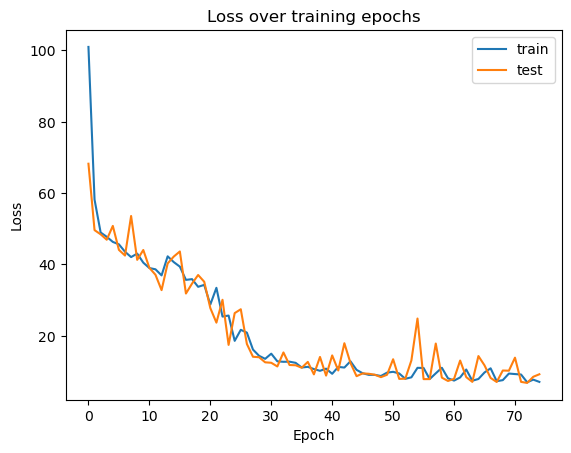

In [21]:
loss_plot(history)

Define a function to predict the loss of a given dataset.

In [22]:
def predict(model, dataset):
    dataset = DataLoader(dataset, batch_size=1, shuffle=False)
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
      model = model.eval()
      for seq_true in dataset:
        seq_true = seq_true[0]
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)

        predictions.append(seq_pred.cpu().numpy().flatten())
        losses.append(loss.item())
    return predictions, losses

To find the threshold of nouvelty detection, we need to plot the loss of normal dataset by histogram. 

c:\Users\joels\anaconda3\envs\SDD\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'MSE Loss')

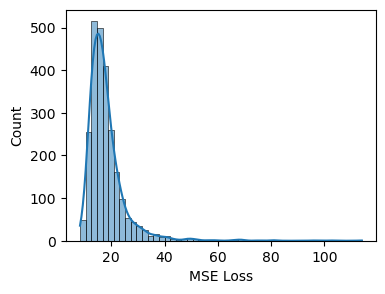

In [23]:
model = model_LSTM
_, losses = predict(model, train_dataset)
plt.figure(figsize=(4,3))
sns.histplot(losses, bins=50, kde=True);
plt.xlabel('MSE Loss')

We can see that the most loss values are distributed around 20, and less than 40. So we can try to set our threshold as 40.

In [24]:
THRESHOLD = 40

Here we verify the threshold by two datasets, one is `test_normal_dataset`, which is a litle part of validation set. The other is `test_anomaly_dataset`, which contains all 2081 anomaly ECGs. 

c:\Users\joels\anaconda3\envs\SDD\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\joels\anaconda3\envs\SDD\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


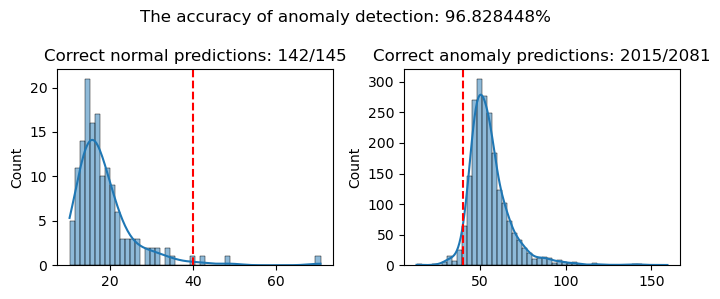

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

predictions, pred_losses = predict(model, test_normal_dataset)
correct = sum(l <= THRESHOLD for l in pred_losses)
sns.histplot(pred_losses, bins=50, kde=True ,ax=axes[0]);
axes[0].set_title(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

predictions, pred_losses = predict(model, test_anomaly_dataset)
correct = sum(l > THRESHOLD for l in pred_losses)
sns.histplot(pred_losses, bins=50, kde=True ,ax=axes[1]);
axes[1].set_title(f'Correct anomaly predictions: {correct}/{len(test_anomaly_dataset)}')

for ax in axes:
  ax.axvline(x=THRESHOLD, color='red', linestyle='--')

plt.suptitle(f"The accuracy of anomaly detection: {correct/len(test_anomaly_dataset)*100}%")
plt.tight_layout()

Here we define a function to sample randomly from normal and anomaly datasets then shows their true ECG and predicted ECG. Try some times to see the results in different ECG.

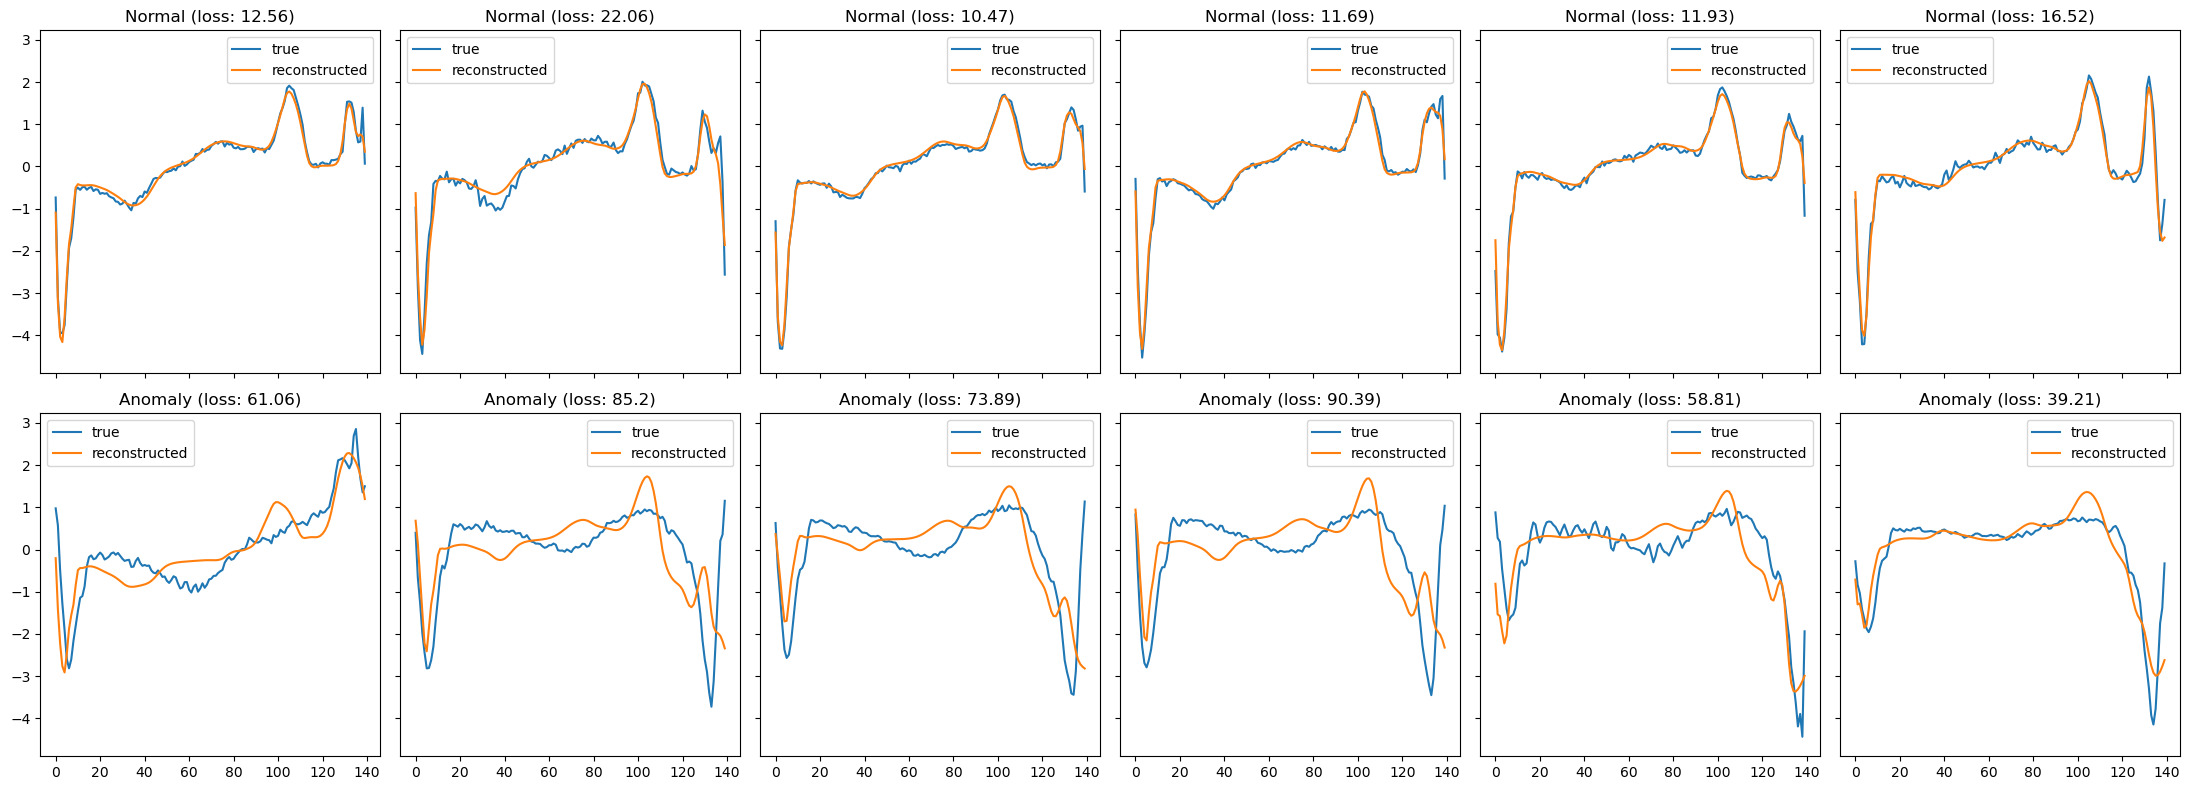

In [28]:
# Defining auxiliary functions
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data.unsqueeze(0)])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()
# plot
fig, axs = plt.subplots(
              nrows=2,
              ncols=6,
              sharey=True,
              sharex=True,
              figsize=(22, 8)
            )

# choose randomly from datasets
idx_normal = np.random.choice(len(test_normal_dataset))
idx_anomaly = np.random.choice(len(test_anomaly_dataset))

for i, data in enumerate(test_normal_dataset[idx_normal-6:idx_normal][0]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[idx_anomaly-6:idx_anomaly][0]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()

We find that the LSTM encoder can find anomaly ECGs with an accuracy 96.8%. It can reconstruct the normal ECG and keep a larger loss value after the reconstruction of abnormal ECG.

Finally we save the model.

In [29]:
# MODEL_PATH = '/content/model_LSTM.pth'
# torch.save(model_LSTM, MODEL_PATH)
# with open('history_LSTM.json', 'w') as f:
#     json.dump(history, f)

# <a id="sec3"></a>3. Bidirectional LSTM Autoencoder

<a href="https://github.com/swati1504/BIDIRECTIONAL-LSTM-FROM-SCRATCH"><img src="img/BLSTM2.png" width="600"></img></a>

A Bidirectional LSTM (biLSTM) is a sequence processing model that consists of two LSTMs: one taking the input in a forward direction, and the other in a backwards direction. The output layer can get information from past and future states simultaneously.

## 3.1 Create model

Since we have two directions, if we set parameter `birectional=True`, the output size of LSTM is `2*hidden_size`. Thus we have a new architecture:

- Input: (30,140,1)
- Bi-LSTM1: `hidden_size=128`, (30,140,1) -> (30,140,256)
- Bi-LSTM2: `hidden_size=128`, (30,140,256) -> (30,140,256)
- Linear reshape: (30,140,56) -> (30,256)

Now it's your turn! Les's write a new Autoencoder!

<div class="alert alert-success">

**Exercise1**: Based on LSTM_encoder, rewrite BLSTM_Encoder according to the architecture above. 

**Hint**: Size of `hidden_n` will change here (num_layers*num_directions, batch_size, features_dim), so don't forget to change `batch_size` to the first place before reshaping, to avoid lose imformation.

</div>

In [29]:
# %load solutions/BLSTM_Encoder.py

class BLSTM_Encoder(nn.Module):

#Define a subclass of encoder that inherits from the parent class nn.Modul

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(BLSTM_Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

  # use to layers of LSTMs
    self.rnn1 = nn.LSTM(
        # To do
        
        )

    self.rnn2 = nn.LSTM(
       # To do
       
       )


  def forward(self, x):
    x, _ = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    hidden_n = hidden_n.permute(1, 0, 2)
    # shape of hidden_n：(num_layers*num_directions, batch_size, embedding_dim)
    return # To do

In [31]:
class BLSTM_Encoder(nn.Module):

#Define a subclass of encoder that inherits from the parent class nn.Modul

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(BLSTM_Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

  # use to layers of LSTMs
    self.rnn1 = nn.LSTM(
        input_size=n_features,
        hidden_size=self.hidden_dim,
        num_layers=1,
        bidirectional=True, # here to open bidirectional LSTM
        batch_first=True)

    self.rnn2 = nn.LSTM(
        input_size=self.hidden_dim * 2, # the output of last layer doubled
        hidden_size=self.hidden_dim,
        num_layers=1,
        bidirectional=True,  # here to open bidirectional LSTM
        batch_first=True)


  def forward(self, x):
    x, _ = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    hidden_n = hidden_n.permute(1, 0, 2)
    # shape of hidden_n：(num_layers*num_directions, batch_size, embedding_dim)
    return hidden_n.reshape((-1,self.hidden_dim*2))

Now test the output size.

In [39]:
encoder = BLSTM_Encoder(seq_len=seq_len, n_features=n_features)
x = torch.randn((30, seq_len, n_features))
output = encoder(x)
print(f"The shape after encoding of input (30,140,1): {output.shape}")

The shape after encoding of input (30,140,1): torch.Size([30, 256])


The same way for BLSTM_Decoder. **Attention**: we use LSTM, not Bi-LSTM for decoder.

- Input: (30,256)
- Reshape: (30,256) -> (30,1,256)
- Repeat: (30,1,256) -> (30,140,256)
- LSTM1: `hidden_size=128`, (30,140,256) -> (30,140,128)
- LSTM2: `hidden_size=256`, (30,140,128) -> (30,140,256)
- Linear reshape: (30,140,256) -> (30,140,1)

<div class="alert alert-success">

**Exercise2**: Based on LSTM_Decoder, rewrite BLSTM_Decoder according to the architecture above. 

</div>

In [30]:
# %load ./solutions/BLSTM_Decoder.py
class BLSTM_Decoder(nn.Module):

  def __init__(self, seq_len, n_features=1, input_dim=64,):
    super(BLSTM_Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 4 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      # to do
      num_layers=1,
      batch_first=True)

    self.rnn2 = nn.LSTM(
      # to do
      num_layers=1,
      batch_first=True)

    self.output_layer = nn.Linear(self.hidden_dim,self.n_features) #

  def forward(self, x):
      x = x.reshape((-1,1,self.input_dim*4)) #
      x = x.repeat(1,self.seq_len,1)
      x, _ = self.rnn1(x)
      x, _ = self.rnn2(x)
      return self.output_layer(x)

In [32]:
class BLSTM_Decoder(nn.Module):

  def __init__(self, seq_len, n_features=1, input_dim=64,):
    super(BLSTM_Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 4 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=self.input_dim * 4,  #
      hidden_size=self.input_dim * 2,
      num_layers=1,
      batch_first=True)

    self.rnn2 = nn.LSTM(
      input_size=self.input_dim * 2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True)

    self.output_layer = nn.Linear(self.hidden_dim,self.n_features) #

  def forward(self, x):
      x = x.reshape((-1,1,self.input_dim*4)) #
      x = x.repeat(1,self.seq_len,1)
      x, _ = self.rnn1(x)
      x, _ = self.rnn2(x)
      return self.output_layer(x)

Test the size of output.

In [41]:
output = torch.randn((30, 256))
decoder = BLSTM_Decoder(seq_len, n_features, 64,)
output = decoder(output)
print(f"The shape after decoding of input (30,256): {output.shape}")

The shape after decoding of input (30,256): torch.Size([30, 140, 1])


Define a new model `BLSTMAutoencoder` and show its information.

In [44]:
class BLSTMAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, hidden_dim=64):
      super(BLSTMAutoencoder, self).__init__()
      self.encoder = BLSTM_Encoder(seq_len, n_features, hidden_dim).to(device)
      self.decoder = BLSTM_Decoder(seq_len, n_features, hidden_dim).to(device)

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

In [45]:
model_BLSTM = BLSTMAutoencoder(seq_len, n_features, 128)
model_BLSTM = model_BLSTM.to(device)
batch_size = 30 # assume that batch size is 30
summary(model_BLSTM, input_size=(batch_size, 140, 1))

Layer (type:depth-idx)                   Output Shape              Param #
BLSTMAutoencoder                         [30, 140, 1]              --
├─BLSTM_Encoder: 1-1                     [30, 512]                 --
│    └─LSTM: 2-1                         [30, 140, 512]            530,432
│    └─LSTM: 2-2                         [30, 140, 512]            1,576,960
├─BLSTM_Decoder: 1-2                     [30, 140, 1]              --
│    └─LSTM: 2-3                         [30, 140, 256]            788,480
│    └─LSTM: 2-4                         [30, 140, 512]            1,576,960
│    └─Linear: 2-5                       [30, 140, 1]              513
Total params: 4,473,345
Trainable params: 4,473,345
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 18.79
Input size (MB): 0.02
Forward/backward pass size (MB): 60.24
Params size (MB): 17.89
Estimated Total Size (MB): 78.16

## 3.2 Train 

We use the same train function and the same dataloaders.

<div class="alert alert-danger">

- Skip the first block and run the second block for training. If you are using T4 GPU of Colab, the train process may take 3 mins. 

- Or, you can load the trained model and results and skip the second block in the following.

</div>

In [49]:
with open('./models/history_BLSTM.json', 'r') as f:
    history = json.load(f)

model_BLSTM = torch.load('./models/model_BLSTM.pth', map_location=torch.device('cpu'))

In [38]:
# Here to run the precess of train, it may take a few of time
start_time_train = time.time()
model_BLSTM, history = train_model(
  model_BLSTM,
  train_loader,
  val_dataset,
  n_epochs=80
)
end_time_train = time.time()
print(f"Train time: {end_time_train-start_time_train}s")

Training:   1%|▏         | 1/80 [00:06<08:39,  6.58s/it]

 Epoch 1: train loss 139.62525083926798 val loss 223.28127520564473


Training:   2%|▎         | 2/80 [00:12<08:17,  6.38s/it]

 Epoch 2: train loss 140.97164539155506 val loss 138.0526330316433


Training:   4%|▍         | 3/80 [00:20<08:51,  6.91s/it]

 Epoch 3: train loss 133.57173576787486 val loss 122.96003056548967


Training:   5%|▌         | 4/80 [00:26<08:23,  6.62s/it]

 Epoch 4: train loss 133.7067420180963 val loss 130.00491421540036


Training:   6%|▋         | 5/80 [00:32<08:06,  6.49s/it]

 Epoch 5: train loss 120.84802229485543 val loss 109.79810807159737


Training:   8%|▊         | 6/80 [00:39<07:54,  6.41s/it]

 Epoch 6: train loss 79.66007477291045 val loss 63.0829093334211


Training:   9%|▉         | 7/80 [00:46<08:16,  6.80s/it]

 Epoch 7: train loss 55.21560051673664 val loss 49.15992886540019


Training:  10%|█         | 8/80 [00:55<08:49,  7.35s/it]

 Epoch 8: train loss 47.8825898116408 val loss 45.75564431981422


Training:  11%|█▏        | 9/80 [01:02<08:39,  7.32s/it]

 Epoch 9: train loss 44.34430201523969 val loss 42.0927559198373


Training:  12%|█▎        | 10/80 [01:08<08:10,  7.00s/it]

 Epoch 10: train loss 40.944873531281004 val loss 39.49505917936462


Training:  14%|█▍        | 11/80 [01:15<07:47,  6.78s/it]

 Epoch 11: train loss 39.10108017002374 val loss 39.856406527574556


Training:  15%|█▌        | 12/80 [01:21<07:30,  6.62s/it]

 Epoch 12: train loss 39.99715410089817 val loss 37.37548187568326


Training:  16%|█▋        | 13/80 [01:27<07:17,  6.53s/it]

 Epoch 13: train loss 38.33843057853024 val loss 37.90190394339708


Training:  18%|█▊        | 14/80 [01:33<07:06,  6.46s/it]

 Epoch 14: train loss 36.846214519336385 val loss 37.35755264881121


Training:  19%|█▉        | 15/80 [01:40<07:03,  6.51s/it]

 Epoch 15: train loss 37.17616808279301 val loss 38.306238516198896


Training:  20%|██        | 16/80 [01:46<06:53,  6.47s/it]

 Epoch 16: train loss 35.984493624109795 val loss 33.205937118660465


Training:  21%|██▏       | 17/80 [01:53<06:55,  6.59s/it]

 Epoch 17: train loss 36.28709810218032 val loss 40.77534133338277


Training:  22%|██▎       | 18/80 [02:00<06:44,  6.53s/it]

 Epoch 18: train loss 37.4853555415493 val loss 36.08744441283034


Training:  24%|██▍       | 19/80 [02:06<06:41,  6.58s/it]

 Epoch 19: train loss 36.11393807685835 val loss 35.99689623927094


Training:  25%|██▌       | 20/80 [02:13<06:31,  6.53s/it]

 Epoch 20: train loss 34.67485682342598 val loss 34.08122759223391


Training:  26%|██▋       | 21/80 [02:19<06:22,  6.49s/it]

 Epoch 21: train loss 33.73509401074883 val loss 39.19042707710136


Training:  28%|██▊       | 22/80 [02:26<06:14,  6.46s/it]

 Epoch 22: train loss 32.65613895338409 val loss 26.935444913219673


Training:  29%|██▉       | 23/80 [02:32<06:06,  6.44s/it]

 Epoch 23: train loss 28.59963807951566 val loss 30.688409180364513


Training:  30%|███       | 24/80 [02:38<05:59,  6.42s/it]

 Epoch 24: train loss 27.366353020700465 val loss 23.01456985375987


Training:  31%|███▏      | 25/80 [02:45<05:59,  6.54s/it]

 Epoch 25: train loss 21.96437589684311 val loss 26.84768229865377


Training:  32%|███▎      | 26/80 [02:52<05:57,  6.62s/it]

 Epoch 26: train loss 22.014523734094876 val loss 20.780747872570675


Training:  34%|███▍      | 27/80 [02:58<05:47,  6.56s/it]

 Epoch 27: train loss 19.473382769041862 val loss 16.638882721650315


Training:  35%|███▌      | 28/80 [03:05<05:47,  6.68s/it]

 Epoch 28: train loss 16.693259583903547 val loss 12.761587885866392


Training:  36%|███▋      | 29/80 [03:12<05:37,  6.62s/it]

 Epoch 29: train loss 13.719047504866207 val loss 12.279860446070648


Training:  38%|███▊      | 30/80 [03:18<05:31,  6.63s/it]

 Epoch 30: train loss 14.204534382722814 val loss 14.263350074201721


Training:  39%|███▉      | 31/80 [03:25<05:23,  6.61s/it]

 Epoch 31: train loss 13.70146723809967 val loss 13.02907388120788


Training:  40%|████      | 32/80 [03:32<05:17,  6.62s/it]

 Epoch 32: train loss 12.7758093524682 val loss 10.594875600964542


Training:  41%|████▏     | 33/80 [03:38<05:14,  6.68s/it]

 Epoch 33: train loss 10.298318832639662 val loss 10.787924454073858


Training:  42%|████▎     | 34/80 [03:45<05:07,  6.69s/it]

 Epoch 34: train loss 10.302782765429578 val loss 10.271586576012622


Training:  44%|████▍     | 35/80 [03:53<05:18,  7.07s/it]

 Epoch 35: train loss 10.105654786125063 val loss 12.39787796577089


Training:  45%|████▌     | 36/80 [04:00<05:05,  6.94s/it]

 Epoch 36: train loss 10.417181254622616 val loss 9.373416491335977


Training:  46%|████▋     | 37/80 [04:07<04:58,  6.94s/it]

 Epoch 37: train loss 8.67647071198271 val loss 14.379598655798329


Training:  48%|████▊     | 38/80 [04:13<04:47,  6.85s/it]

 Epoch 38: train loss 10.199656111529086 val loss 8.938461281740624


Training:  49%|████▉     | 39/80 [04:20<04:37,  6.76s/it]

 Epoch 39: train loss 9.00543718921895 val loss 7.249375690372323


Training:  50%|█████     | 40/80 [04:26<04:28,  6.71s/it]

 Epoch 40: train loss 8.795750477416716 val loss 7.219015923376376


Training:  51%|█████▏    | 41/80 [04:33<04:19,  6.65s/it]

 Epoch 41: train loss 7.433572178362717 val loss 7.203505871238969


Training:  52%|█████▎    | 42/80 [04:40<04:14,  6.71s/it]

 Epoch 42: train loss 7.984284938544103 val loss 9.045486775681427


Training:  54%|█████▍    | 43/80 [04:46<04:06,  6.66s/it]

 Epoch 43: train loss 6.795066343900027 val loss 6.036761615463491


Training:  55%|█████▌    | 44/80 [04:54<04:05,  6.81s/it]

 Epoch 44: train loss 7.139759110431282 val loss 6.846025639019729


Training:  56%|█████▋    | 45/80 [05:00<03:56,  6.76s/it]

 Epoch 45: train loss 6.705002616484419 val loss 19.374231709555147


Training:  57%|█████▊    | 46/80 [05:07<03:49,  6.76s/it]

 Epoch 46: train loss 8.24736393173806 val loss 7.3356587260249535


Training:  59%|█████▉    | 47/80 [05:14<03:41,  6.72s/it]

 Epoch 47: train loss 6.3940497530290585 val loss 5.575802652095365


Training:  60%|██████    | 48/80 [05:20<03:34,  6.70s/it]

 Epoch 48: train loss 5.608497384345991 val loss 7.147270217283594


Training:  61%|██████▏   | 49/80 [05:27<03:28,  6.73s/it]

 Epoch 49: train loss 6.753196733608808 val loss 6.03171822398189


Training:  62%|██████▎   | 50/80 [05:34<03:20,  6.70s/it]

 Epoch 50: train loss 5.5514884351873075 val loss 9.252079029538933


Training:  64%|██████▍   | 51/80 [05:41<03:18,  6.84s/it]

 Epoch 51: train loss 6.397789504901081 val loss 6.4390863668389695


Training:  65%|██████▌   | 52/80 [05:47<03:09,  6.76s/it]

 Epoch 52: train loss 6.8879118220876405 val loss 6.459731708614493


Training:  66%|██████▋   | 53/80 [05:54<03:02,  6.77s/it]

 Epoch 53: train loss 5.5637983066965395 val loss 6.29303338503268


Training:  68%|██████▊   | 54/80 [06:01<02:54,  6.72s/it]

 Epoch 54: train loss 5.418670671597089 val loss 5.236047102729615


Training:  69%|██████▉   | 55/80 [06:08<02:51,  6.85s/it]

 Epoch 55: train loss 5.238353982696188 val loss 6.593141410944812


Training:  70%|███████   | 56/80 [06:15<02:43,  6.80s/it]

 Epoch 56: train loss 6.411772135001461 val loss 7.784214666679044


Training:  71%|███████▏  | 57/80 [06:21<02:35,  6.74s/it]

 Epoch 57: train loss 6.601672977438859 val loss 7.459329885427455


Training:  72%|███████▎  | 58/80 [06:28<02:31,  6.88s/it]

 Epoch 58: train loss 6.0447133200509215 val loss 5.965830378158101


Training:  74%|███████▍  | 59/80 [06:35<02:22,  6.80s/it]

 Epoch 59: train loss 5.128208261606645 val loss 4.915038443059237


Training:  75%|███████▌  | 60/80 [06:42<02:16,  6.84s/it]

 Epoch 60: train loss 4.423315312046043 val loss 5.51786442624831


Training:  76%|███████▋  | 61/80 [06:49<02:09,  6.80s/it]

 Epoch 61: train loss 5.59777129469545 val loss 9.559035503009888


Training:  78%|███████▊  | 62/80 [06:55<02:01,  6.76s/it]

 Epoch 62: train loss 5.496406992871204 val loss 4.577352306948587


Training:  79%|███████▉  | 63/80 [07:02<01:54,  6.73s/it]

 Epoch 63: train loss 4.905751816972313 val loss 4.483727337150444


Training:  80%|████████  | 64/80 [07:09<01:47,  6.71s/it]

 Epoch 64: train loss 4.397501240944376 val loss 6.024592452488662


Training:  81%|████████▏ | 65/80 [07:16<01:42,  6.86s/it]

 Epoch 65: train loss 5.082146441747272 val loss 4.205411468349626


Training:  82%|████████▎ | 66/80 [07:23<01:35,  6.79s/it]

 Epoch 66: train loss 6.009703243887072 val loss 5.960770692841591


Training:  84%|████████▍ | 67/80 [07:30<01:29,  6.86s/it]

 Epoch 67: train loss 4.543121248794522 val loss 4.843247222819019


Training:  85%|████████▌ | 68/80 [07:36<01:21,  6.78s/it]

 Epoch 68: train loss 5.820668803104738 val loss 4.588497921468455


Training:  86%|████████▋ | 69/80 [07:43<01:14,  6.74s/it]

 Epoch 69: train loss 4.335640966540832 val loss 3.7661849390524647


Training:  88%|████████▊ | 70/80 [07:49<01:07,  6.70s/it]

 Epoch 70: train loss 4.284497032252029 val loss 3.941568417964128


Training:  89%|████████▉ | 71/80 [07:56<01:00,  6.68s/it]

 Epoch 71: train loss 4.690037296148114 val loss 3.833871508214254


Training:  90%|█████████ | 72/80 [08:03<00:54,  6.78s/it]

 Epoch 72: train loss 5.133183403620644 val loss 4.8341050949519815


Training:  91%|█████████▏| 73/80 [08:10<00:47,  6.73s/it]

 Epoch 73: train loss 4.060399997045123 val loss 6.617809595101522


Training:  92%|█████████▎| 74/80 [08:17<00:41,  6.86s/it]

 Epoch 74: train loss 5.415742175216847 val loss 3.882324298290669


Training:  94%|█████████▍| 75/80 [08:24<00:34,  6.85s/it]

 Epoch 75: train loss 3.6084566207159137 val loss 3.7402891368182445


Training:  95%|█████████▌| 76/80 [08:30<00:27,  6.78s/it]

 Epoch 76: train loss 5.724682285023385 val loss 4.714969399846048


Training:  96%|█████████▋| 77/80 [08:37<00:20,  6.73s/it]

 Epoch 77: train loss 4.428309636537721 val loss 5.605997055463823


Training:  98%|█████████▊| 78/80 [08:44<00:13,  6.70s/it]

 Epoch 78: train loss 4.511521453165414 val loss 8.587191215554196


Training:  99%|█████████▉| 79/80 [08:50<00:06,  6.76s/it]

 Epoch 79: train loss 4.630520652373091 val loss 9.581019948366967


Training: 100%|██████████| 80/80 [08:57<00:00,  6.72s/it]

 Epoch 80: train loss 6.130720638525999 val loss 4.350401159846335
Train time: 537.5801360607147s


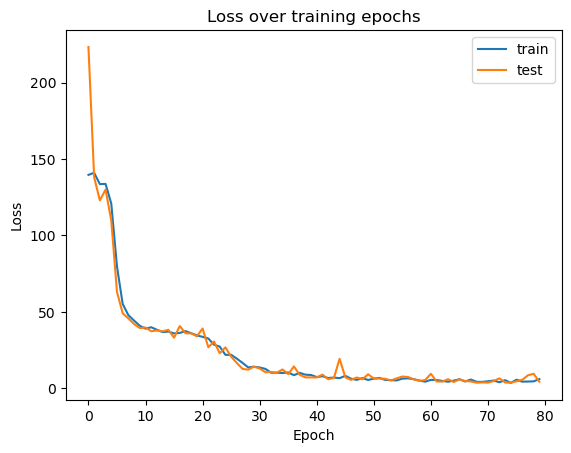

In [47]:
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

To find the threshold of nouvelty detection, we need to plot the loss of normal dataset by histogram. 

c:\Users\joels\anaconda3\envs\SDD\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

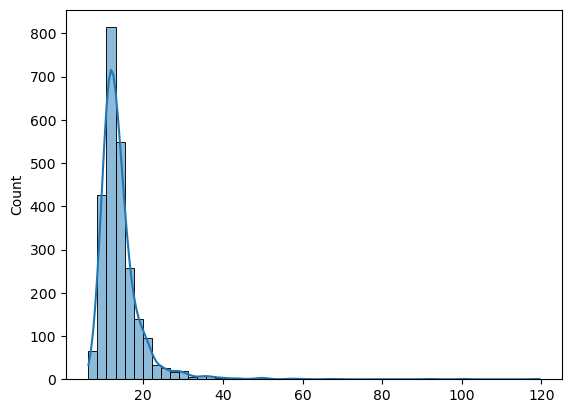

In [50]:
model = model_BLSTM
_, losses = predict(model, train_dataset)
sns.histplot(losses, bins=50, kde=True)

We can see that the most loss values are distributed around 10, and less than 26, which is less than the result of LSTM model. So we can try to set our threshold as 26. 

In [51]:
THRESHOLD = 26

c:\Users\joels\anaconda3\envs\SDD\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\joels\anaconda3\envs\SDD\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


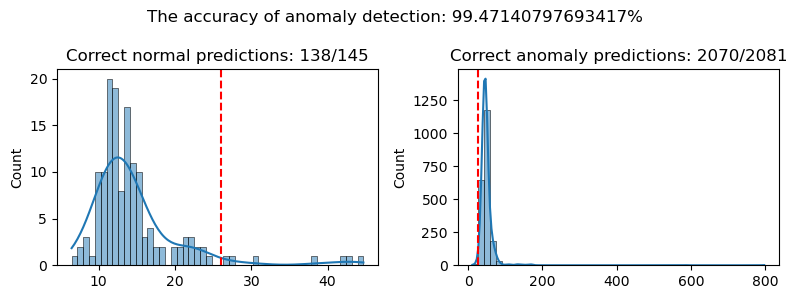

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

predictions, pred_losses = predict(model, test_normal_dataset)
correct = sum(l <= THRESHOLD for l in pred_losses)
sns.histplot(pred_losses, bins=50, kde=True ,ax=axes[0]);
axes[0].set_title(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

predictions, pred_losses = predict(model, test_anomaly_dataset)
correct = sum(l > THRESHOLD for l in pred_losses)
sns.histplot(pred_losses, bins=50, kde=True ,ax=axes[1]);
axes[1].set_title(f'Correct anomaly predictions: {correct}/{len(test_anomaly_dataset)}')

for ax in axes:
  ax.axvline(x=THRESHOLD, color='red', linestyle='--')

plt.suptitle(f"The accuracy of anomaly detection: {correct/len(test_anomaly_dataset)*100}%")
plt.tight_layout()

Here we define a function to sample randomly from normal and anomaly datasets then shows their true ECG and predicted ECG. Try some times to see the results in different ECG.

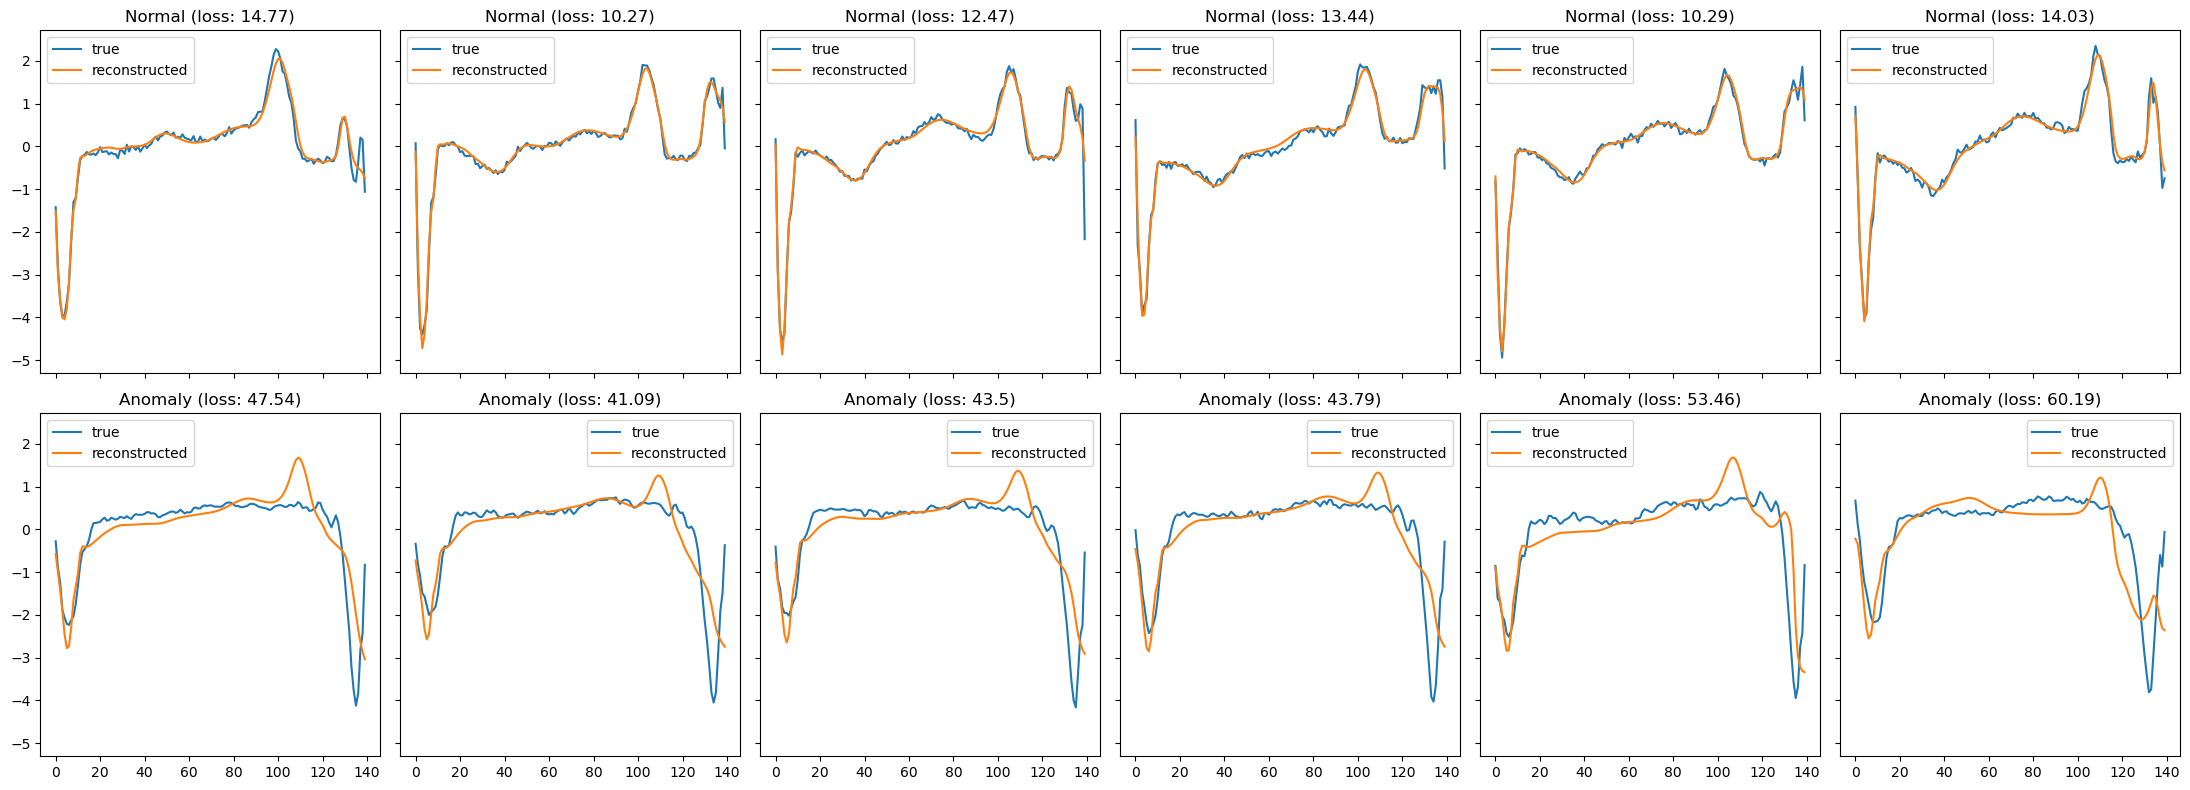

In [57]:
# Defining auxiliary functions
def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data.unsqueeze(0)])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()
# plot
fig, axs = plt.subplots(
              nrows=2,
              ncols=6,
              sharey=True,
              sharex=True,
              figsize=(22, 8)
            )

idx_normal = np.random.choice(len(test_normal_dataset))
idx_anomaly = np.random.choice(len(test_anomaly_dataset))

for i, data in enumerate(test_normal_dataset[idx_normal-6:idx_normal][0]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[idx_anomaly-6:idx_anomaly][0]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])
    
fig.tight_layout();

We can find that the accuracy has increased to 99.5%, and the train loss is smaller than that of LSTM autoencoder, which means that Bidirectional LSTM can help increse the precision. But as a bidirectional RNN model, the time of training and prediction has also increased. 

In [44]:
# Save the trained model
# MODEL_PATH = '/content/model_BLSTM.pth'
# torch.save(model_BLSTM, MODEL_PATH)
# with open('history_BLSTM.json', 'w') as f:
#     json.dump(history, f)

# <a id="sec4"></a>4. Denoise Bidirectional LSTMs

The idea of denoising autoencoders is quite intuitive. In order to force the hidden layer to retrieve more robust features and prevent it from simply learning the identity, the autoencoder is trained to reconstruct the input from a corrupted version of it.

Formally, the initial input x is corrupted by means of additive isotropic Gaussian noise in order to obtain: $x^{'}|x \sim N(x,2 \sigma ^2 I)$. The corrupted input x is then mapped, as with the basic autoencoder, to a hidden representation.

$$h(x^{'}) = f(W_1^{'}x^{'}+b_1^{'})$$

from which we reconstruct a the original signal as follows:

$$\widetilde{x}^{'}=f(W_2^{'}x+b_2^{'}) $$

The parameters $\theta^{'}=\left \{ W_1^{'}, W_2^{'}, b_1^{'}, b_2^{'}\right \}$ aretrained to minimise the average reconstruction error over the training set, to have $\widetilde{x}^{'}$ as close as possible to the uncorrupted input $x$, which corresponds to minimising the objective MSE loss function.

Here is a illustration of [denoising autoencoder model architecture](https://lilianweng.github.io/posts/2018-08-12-vae/)(DAE).

<img src="./img/denoising-autoencoder-architecture.png" width=700>



In [45]:
model_BLSTM_DAE = BLSTMAutoencoder(seq_len, n_features, 128)
model_BLSTM_DAE = model_BLSTM_DAE.to(device)

So here we use the same autoencoder model but change the train function to add a set of noise  $N(x, \sigma^{2} I)$ to input datasets.

<div class="alert alert-success">

**Exercise3**: Based on train function before, rewrite `train_model` according to the architecture above. 

</div>

In [58]:
# %load ./solutions/BLSTM_DAE_train.py

def train_model(model, train_loader, val_dataset, n_epochs, sigma=0):

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in tqdm(range(1, n_epochs + 1),desc='Training'):
    model = model.train()
    train_losses = []
    for seq in train_loader:

      seq_true = seq[0]
      seq_true = seq_true.to(device)
      # add noise here
      inputs =  # To do
      optimizer.zero_grad()
      inputs = inputs.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, seq_true)
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item()/inputs.shape[0])

    val_losses = []
    model = model.eval()

    with torch.no_grad():
      for seq in val_dataset:

        seq_true = seq[0].unsqueeze(0)
        seq_true = seq_true.to(device)

        # add noise here
        inputs =  #To do
        inputs = inputs.to(device)
        seq_pred = model(inputs)
        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f' Train loss {train_loss} Validation loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [46]:
def train_model(model, train_loader, val_dataset, n_epochs, sigma=0):

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in tqdm(range(1, n_epochs + 1),desc='Training'):
    model = model.train()
    train_losses = []
    for seq in train_loader:

      seq_true = seq[0]
      seq_true = seq_true.to(device)
      # add noise
      inputs = torch.randn_like(seq_true) * sigma * sigma + seq_true
      optimizer.zero_grad()
      inputs = inputs.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, seq_true)
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item()/inputs.shape[0])

    val_losses = []
    model = model.eval()

    with torch.no_grad():
      for seq in val_dataset:

        seq_true = seq[0].unsqueeze(0)
        seq_true = seq_true.to(device)

        # add noise
        inputs = torch.randn_like(seq_true) * sigma * sigma + seq_true
        inputs = inputs.to(device)
        seq_pred = model(inputs)
        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f' Train loss {train_loss} Validation loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

<div class="alert alert-danger">

- Skip the first block and run the second block for training. If you are using T4 GPU of Colab, the train process may take 3 mins. 

- Or, you can load the trained model and results and skip the second block in the following.

</div>

In [64]:
with open('./models/history_BLSTM_DAE.json', 'r') as f:
    history = json.load(f)

model_BLSTM_DAE = torch.load('./models/model_BLSTM_DAE.pth', map_location=torch.device('cpu'))

In [47]:
# Here to run the precess of train, it may take a few of time
start_time_train = time.time()
model_BLSTM_DAE, history = train_model(
  model_BLSTM_DAE,
  train_loader,
  val_dataset,
  n_epochs=80,
  sigma=0.5
)
end_time_train = time.time()
print(f"Train time: {end_time_train-start_time_train}s")

Training:   1%|▏         | 1/80 [00:06<08:23,  6.38s/it]

 Train loss 91.19009207035678 Validation loss 100.90672067896091


Training:   2%|▎         | 2/80 [00:13<08:43,  6.71s/it]

 Train loss 94.60094207279266 Validation loss 93.36869934394498


Training:   4%|▍         | 3/80 [00:20<09:04,  7.07s/it]

 Train loss 94.15260281032985 Validation loss 92.62524455724723


Training:   5%|▌         | 4/80 [00:27<08:37,  6.81s/it]

 Train loss 92.43970006133964 Validation loss 87.65612243548188


Training:   6%|▋         | 5/80 [00:33<08:18,  6.64s/it]

 Train loss 94.80198296440973 Validation loss 92.3579506206838


Training:   8%|▊         | 6/80 [00:39<08:05,  6.56s/it]

 Train loss 92.209280250186 Validation loss 91.73193908795562


Training:   9%|▉         | 7/80 [00:46<08:04,  6.63s/it]

 Train loss 89.38632286573484 Validation loss 86.29424574920341


Training:  10%|█         | 8/80 [00:53<07:51,  6.55s/it]

 Train loss 91.1321129346921 Validation loss 92.02879934994434


Training:  11%|█▏        | 9/80 [00:59<07:49,  6.61s/it]

 Train loss 94.6555122358188 Validation loss 93.28936449903676


Training:  12%|█▎        | 10/80 [01:06<07:37,  6.54s/it]

 Train loss 93.37705880854946 Validation loss 92.17534194790056


Training:  14%|█▍        | 11/80 [01:13<07:40,  6.67s/it]

 Train loss 92.10027007710636 Validation loss 90.6820629237048


Training:  15%|█▌        | 12/80 [01:19<07:28,  6.60s/it]

 Train loss 92.65678417525865 Validation loss 92.12414988234589


Training:  16%|█▋        | 13/80 [01:26<07:23,  6.62s/it]

 Train loss 91.98807223573023 Validation loss 89.18039601817473


Training:  18%|█▊        | 14/80 [01:33<07:34,  6.89s/it]

 Train loss 93.0005787959715 Validation loss 84.80999026770478


Training:  19%|█▉        | 15/80 [01:40<07:18,  6.75s/it]

 Train loss 92.89918420493197 Validation loss 91.82492000332465


Training:  20%|██        | 16/80 [01:46<07:08,  6.70s/it]

 Train loss 92.32370815839356 Validation loss 90.92815893908816


Training:  21%|██▏       | 17/80 [01:53<06:57,  6.63s/it]

 Train loss 89.71973530948837 Validation loss 88.56535810659364


Training:  22%|██▎       | 18/80 [02:00<06:59,  6.77s/it]

 Train loss 81.46008677233915 Validation loss 73.91880199445393


Training:  24%|██▍       | 19/80 [02:07<06:56,  6.83s/it]

 Train loss 66.15562576674549 Validation loss 61.07091976595413


Training:  25%|██▌       | 20/80 [02:14<06:49,  6.82s/it]

 Train loss 57.6190225821774 Validation loss 54.66394645769034


Training:  26%|██▋       | 21/80 [02:20<06:40,  6.79s/it]

 Train loss 54.214492901652854 Validation loss 56.330981622376946


Training:  28%|██▊       | 22/80 [02:27<06:32,  6.77s/it]

 Train loss 53.617582899859165 Validation loss 52.52259983544464


Training:  29%|██▉       | 23/80 [02:34<06:28,  6.82s/it]

 Train loss 53.73773661157173 Validation loss 55.153039066457914


Training:  30%|███       | 24/80 [02:41<06:19,  6.78s/it]

 Train loss 52.74763517141882 Validation loss 50.62745885230576


Training:  31%|███▏      | 25/80 [02:48<06:19,  6.90s/it]

 Train loss 49.41405602279974 Validation loss 49.41105989710056


Training:  32%|███▎      | 26/80 [02:55<06:07,  6.81s/it]

 Train loss 48.842308864463746 Validation loss 53.5088637485439


Training:  34%|███▍      | 27/80 [03:01<06:00,  6.80s/it]

 Train loss 48.9937912575512 Validation loss 47.39275253998949


Training:  35%|███▌      | 28/80 [03:08<05:49,  6.72s/it]

 Train loss 48.293667817061724 Validation loss 48.3445362312395


Training:  36%|███▋      | 29/80 [03:14<05:40,  6.69s/it]

 Train loss 47.194840038066005 Validation loss 47.24366710780017


Training:  38%|███▊      | 30/80 [03:21<05:32,  6.66s/it]

 Train loss 46.2301521422371 Validation loss 46.63170448667767


Training:  39%|███▉      | 31/80 [03:28<05:25,  6.64s/it]

 Train loss 45.46738841776945 Validation loss 44.769620628487125


Training:  40%|████      | 32/80 [03:35<05:23,  6.74s/it]

 Train loss 44.2412219542765 Validation loss 43.88555285873674


Training:  41%|████▏     | 33/80 [03:41<05:15,  6.71s/it]

 Train loss 42.42753302818523 Validation loss 41.2418028079609


Training:  42%|████▎     | 34/80 [03:48<05:14,  6.84s/it]

 Train loss 42.097539521993696 Validation loss 39.24008116217603


Training:  44%|████▍     | 35/80 [03:55<05:05,  6.78s/it]

 Train loss 39.913364927676795 Validation loss 42.43487583980625


Training:  45%|████▌     | 36/80 [04:02<04:56,  6.74s/it]

 Train loss 40.180528138175845 Validation loss 41.24983680777176


Training:  46%|████▋     | 37/80 [04:08<04:48,  6.71s/it]

 Train loss 34.081008606649036 Validation loss 37.85856917449639


Training:  48%|████▊     | 38/80 [04:15<04:40,  6.69s/it]

 Train loss 33.32991530922265 Validation loss 31.08815965229334


Training:  49%|████▉     | 39/80 [04:22<04:37,  6.77s/it]

 Train loss 28.570766679067464 Validation loss 33.75609238074501


Training:  50%|█████     | 40/80 [04:29<04:28,  6.71s/it]

 Train loss 25.137897877249856 Validation loss 31.204821433630414


Training:  51%|█████▏    | 41/80 [04:36<04:26,  6.84s/it]

 Train loss 28.011340795676997 Validation loss 30.739624205709724


Training:  52%|█████▎    | 42/80 [04:42<04:17,  6.77s/it]

 Train loss 25.789555846752766 Validation loss 27.832943047272874


Training:  54%|█████▍    | 43/80 [04:49<04:09,  6.74s/it]

 Train loss 25.69587536593413 Validation loss 22.835351172567634


Training:  55%|█████▌    | 44/80 [04:55<04:00,  6.69s/it]

 Train loss 22.810619930345187 Validation loss 26.25760033187606


Training:  56%|█████▋    | 45/80 [05:02<03:53,  6.66s/it]

 Train loss 25.416527918947526 Validation loss 22.158660276757978


Training:  57%|█████▊    | 46/80 [05:09<03:46,  6.65s/it]

 Train loss 21.796398773539362 Validation loss 28.783099161480067


Training:  59%|█████▉    | 47/80 [05:15<03:40,  6.67s/it]

 Train loss 21.601716188184255 Validation loss 22.289299906317286


Training:  60%|██████    | 48/80 [05:23<03:38,  6.83s/it]

 Train loss 20.91996218449945 Validation loss 20.522082719379725


Training:  61%|██████▏   | 49/80 [05:29<03:29,  6.77s/it]

 Train loss 19.94643756061995 Validation loss 22.200181742983872


Training:  62%|██████▎   | 50/80 [05:36<03:24,  6.81s/it]

 Train loss 21.693280271499873 Validation loss 19.66523685715711


Training:  64%|██████▍   | 51/80 [05:43<03:16,  6.76s/it]

 Train loss 19.968570541416437 Validation loss 20.806438934274095


Training:  65%|██████▌   | 52/80 [05:49<03:07,  6.71s/it]

 Train loss 20.520178530600067 Validation loss 24.934613725837995


Training:  66%|██████▋   | 53/80 [05:56<03:00,  6.68s/it]

 Train loss 19.96177085824564 Validation loss 17.83073714650125


Training:  68%|██████▊   | 54/80 [06:03<02:53,  6.66s/it]

 Train loss 19.694578271982625 Validation loss 21.70678841782918


Training:  69%|██████▉   | 55/80 [06:10<02:49,  6.78s/it]

 Train loss 18.55524748025838 Validation loss 18.43039372349762


Training:  70%|███████   | 56/80 [06:16<02:41,  6.72s/it]

 Train loss 18.178920498456545 Validation loss 20.54700095987157


Training:  71%|███████▏  | 57/80 [06:23<02:37,  6.83s/it]

 Train loss 18.03205647025249 Validation loss 26.377708741015542


Training:  72%|███████▎  | 58/80 [06:30<02:30,  6.86s/it]

 Train loss 18.77775452628968 Validation loss 22.90258155015548


Training:  74%|███████▍  | 59/80 [06:37<02:22,  6.78s/it]

 Train loss 19.762049523178412 Validation loss 17.32308861989617


Training:  75%|███████▌  | 60/80 [06:43<02:14,  6.73s/it]

 Train loss 17.537786882534586 Validation loss 21.025638069309064


Training:  76%|███████▋  | 61/80 [06:50<02:07,  6.69s/it]

 Train loss 19.158753569380227 Validation loss 20.33171155753803


Training:  78%|███████▊  | 62/80 [06:57<02:01,  6.76s/it]

 Train loss 18.7962674891327 Validation loss 16.496756674079766


Training:  79%|███████▉  | 63/80 [07:04<01:54,  6.72s/it]

 Train loss 16.45042752981727 Validation loss 16.079380424356298


Training:  80%|████████  | 64/80 [07:11<01:49,  6.86s/it]

 Train loss 16.328722490583147 Validation loss 16.275247583617123


Training:  81%|████████▏ | 65/80 [07:17<01:41,  6.79s/it]

 Train loss 16.30857115592005 Validation loss 16.085594034032205


Training:  82%|████████▎ | 66/80 [07:24<01:34,  6.74s/it]

 Train loss 17.436053255734258 Validation loss 19.467667914901575


Training:  84%|████████▍ | 67/80 [07:31<01:26,  6.69s/it]

 Train loss 16.62466650376785 Validation loss 17.499693623174988


Training:  85%|████████▌ | 68/80 [07:37<01:20,  6.67s/it]

 Train loss 17.405244515001637 Validation loss 18.58971929712914


Training:  86%|████████▋ | 69/80 [07:44<01:13,  6.71s/it]

 Train loss 16.05609747785019 Validation loss 16.328263582223105


Training:  88%|████████▊ | 70/80 [07:51<01:06,  6.67s/it]

 Train loss 15.686967409440992 Validation loss 19.531544135292236


Training:  89%|████████▉ | 71/80 [07:58<01:01,  6.83s/it]

 Train loss 16.81268954114849 Validation loss 20.377593125092698


Training:  90%|█████████ | 72/80 [08:04<00:54,  6.76s/it]

 Train loss 15.72915309983857 Validation loss 21.14737713784488


Training:  91%|█████████▏| 73/80 [08:11<00:47,  6.75s/it]

 Train loss 16.724934677850634 Validation loss 16.47742971218487


Training:  92%|█████████▎| 74/80 [08:18<00:40,  6.71s/it]

 Train loss 15.831711728881002 Validation loss 14.910724844948831


Training:  94%|█████████▍| 75/80 [08:24<00:33,  6.68s/it]

 Train loss 15.227463412122658 Validation loss 16.107235898743717


Training:  95%|█████████▌| 76/80 [08:31<00:26,  6.66s/it]

 Train loss 17.614223250131758 Validation loss 20.290540770052235


Training:  96%|█████████▋| 77/80 [08:38<00:19,  6.63s/it]

 Train loss 15.677014018294493 Validation loss 15.451966620956265


Training:  98%|█████████▊| 78/80 [08:45<00:13,  6.84s/it]

 Train loss 17.021878453122785 Validation loss 18.034427746977823


Training:  99%|█████████▉| 79/80 [08:52<00:06,  6.78s/it]

 Train loss 16.215089458024423 Validation loss 17.126407473567404


Training: 100%|██████████| 80/80 [08:59<00:00,  6.74s/it]

 Train loss 15.23927519921543 Validation loss 17.1173814669404
Train time: 539.2410652637482s


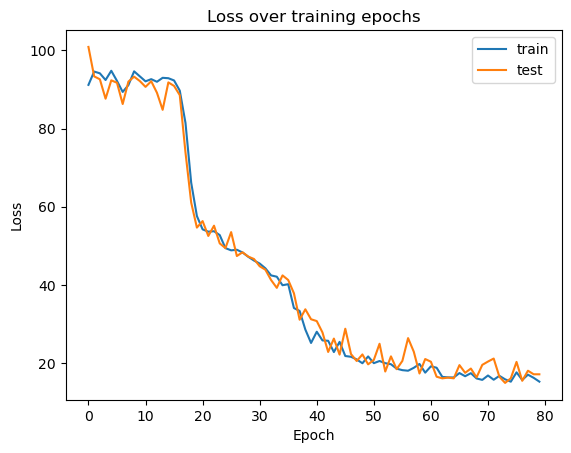

In [61]:
loss_plot(history)

We also add noise to input of prediction.

In [62]:
def predict(model, dataset, sigma=0):
    dataset = DataLoader(dataset, batch_size=1, shuffle=False)
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true[0]
            seq_true = torch.randn_like(seq_true)*sigma*sigma + seq_true
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

c:\Users\joels\anaconda3\envs\SDD\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


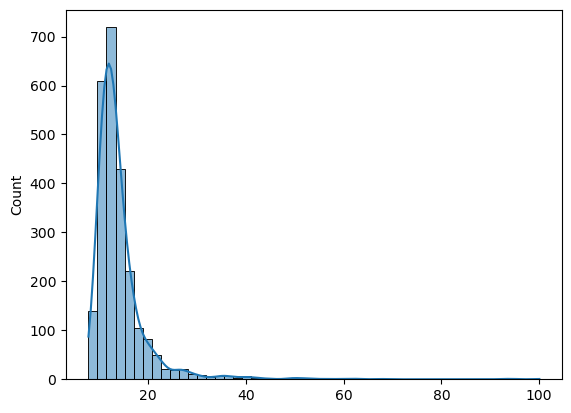

In [65]:
model = model_BLSTM_DAE
_, losses = predict(model, train_dataset, sigma=0.2)
sns.histplot(losses, bins=50, kde=True);

In [66]:
THRESHOLD = 25

c:\Users\joels\anaconda3\envs\SDD\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\joels\anaconda3\envs\SDD\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


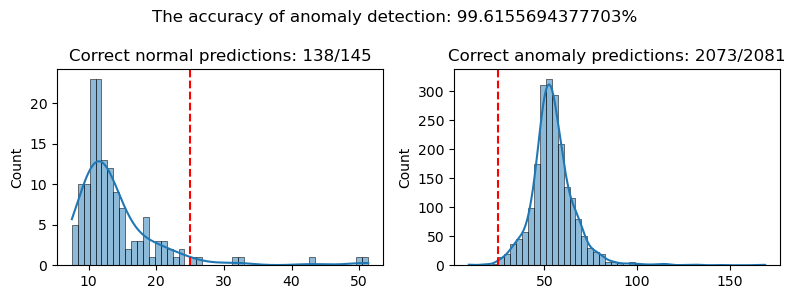

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

predictions, pred_losses = predict(model, test_normal_dataset)
correct = sum(l <= THRESHOLD for l in pred_losses)
sns.histplot(pred_losses, bins=50, kde=True ,ax=axes[0]);
axes[0].set_title(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

predictions, pred_losses = predict(model, test_anomaly_dataset)
correct = sum(l > THRESHOLD for l in pred_losses)
sns.histplot(pred_losses, bins=50, kde=True ,ax=axes[1]);
axes[1].set_title(f'Correct anomaly predictions: {correct}/{len(test_anomaly_dataset)}')

for ax in axes:
  ax.axvline(x=THRESHOLD, color='red', linestyle='--')

plt.suptitle(f"The accuracy of anomaly detection: {correct/len(test_anomaly_dataset)*100}%")
plt.tight_layout()

Here we define a function to sample randomly from normal and anomaly datasets then shows their true ECG and predicted ECG. Try some times to see the results in different ECG.

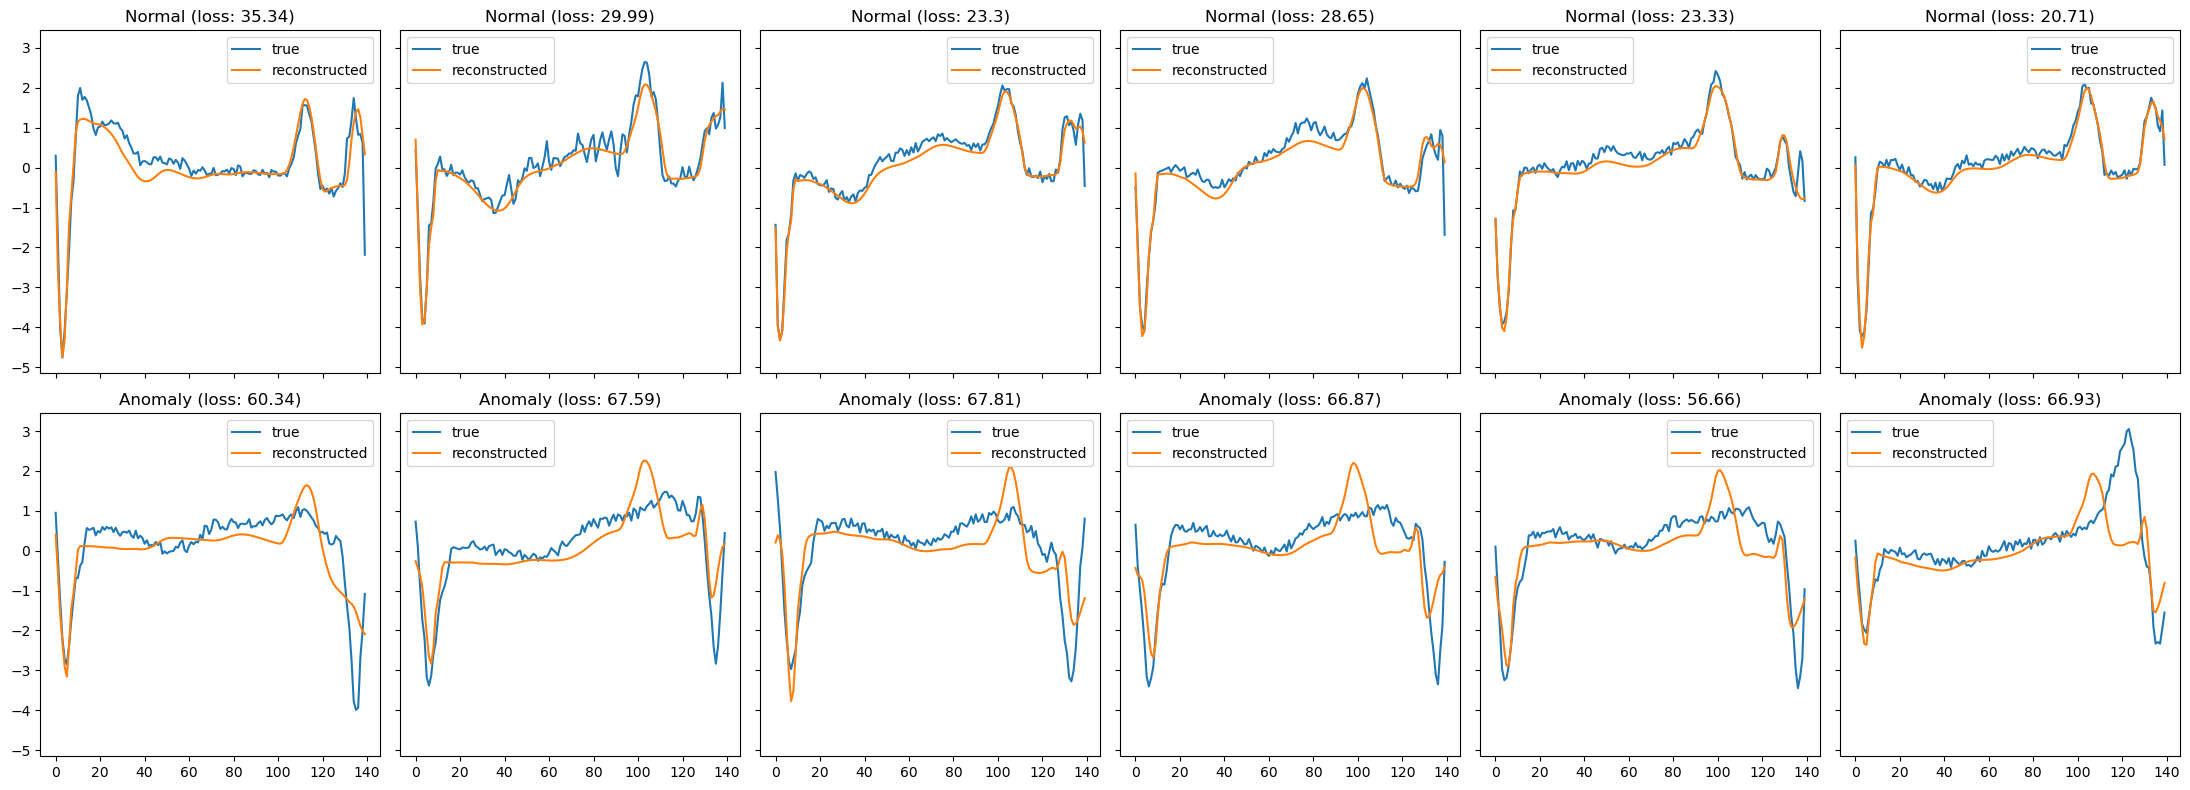

In [68]:
# Defining auxiliary functions
def plot_prediction(data, model, title, ax, sigma=0):
  data = data + torch.rand_like(data)*sigma*sigma  ###
  predictions, pred_losses = predict(model, [data.unsqueeze(0)])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()
# plot
fig, axs = plt.subplots(
              nrows=2,
              ncols=6,
              sharey=True,
              sharex=True,
              figsize=(22, 8)
            )

idx_normal = np.random.choice(len(test_normal_dataset))
idx_anomaly = np.random.choice(len(test_anomaly_dataset))

for i, data in enumerate(test_normal_dataset[idx_normal-6:idx_normal][0]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i], sigma=0.5)

for i, data in enumerate(test_anomaly_dataset[idx_anomaly-6:idx_anomaly][0]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i], sigma=0.5)

fig.tight_layout();

We can see that after denoise Bi-LSTM autoencoder, although we add noise to input, the loss of model after training is quit low. What's more, the accuracy of animaly dection is 99.6%, which is quit high. 

In [56]:
# Save
# MODEL_PATH = '/content/model_BLSTM_DAE.pth'
# torch.save(model_BLSTM_DAE, MODEL_PATH)
# with open('history_BLSTM_DAE.json', 'w') as f:
#     json.dump(history, f)

# <a id="sec5"></a>5. Conclusion

The reference used this model for identifying abnormal sound signals and achieved excellent recognition results even with noisy signals. Here, we applied this model for abnormal analysis of ECG signals. It relies on denoising autoencoders with bidirectional Long Short-Term Memory acting as a one-class classifier. Our Bi-LSTM Denoising Autoencoder(BLSTM-DAE) is able to combine two learning processes: encoding the input by preserving the information about the input, and simultaneously removing the corruption of input. The bidirectional LSTM can help the system to learn more context, and help to increase the accuracy of anomaly detection. The accuracy of detection can be up to 99.5% with BLSTM. And the accuracy of denoising model with Gaissian noise input $\sigma=0.5$ can be up to 99.6%.

For further exploration, we can try to select features of signal and use multi-feature time sequence for training. We can also try to change hidden layers or other parameters to optimize the system.

# Sources

[1] [A NOVEL APPROACH FOR AUTOMATIC ACOUSTIC NOVELTY DETECTION USING A DENOISING AUTOENCODER WITH BIDIRECTIONAL LSTM NEURAL NETWORKS](https://mediatum.ub.tum.de/doc/1253789/file.pdf)

[2] [Framewise Phoneme Classification with Bidirectional LSTM and Other Neural Network Architectures](https://mediatum.ub.tum.de/doc/1290194/document.pdf)

[3] [Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python](https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)

[4] [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[5] [From Autoencoder to Beta-VAE](https://lilianweng.github.io/posts/2018-08-12-vae/)

[6] [Non-linear prediction with LSTM recurrent neural networks for acoustic novelty detection](https://ieeexplore.ieee.org/document/7280757/footnotes#footnotes)